In [1]:
import os
import numpy as np
from pydub import AudioSegment
import librosa
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import pickle
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd
import gradio as gr
import plotly.express as px


/Users/gokulgopank/Documents/Bird_1/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gokulgopank/Documents/Bird_1/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Set directory paths

In [2]:
# Directory paths for input MP3s and output WAVs
input_mp3_dir = 'Voice of Birds/Voice of Birds'
output_wav_dir = 'wav_files'
os.makedirs(output_wav_dir, exist_ok=True)

### Processing audio files
Convert audio files to wav format at 16KHz which is required for YamNet model

In [3]:
# Convert MP3 to WAV with 16kHz
def convert_mp3_to_wav(mp3_path, wav_path):
    sound = AudioSegment.from_mp3(mp3_path)
    sound = sound.set_frame_rate(16000)  # Resample to 16kHz
    sound = sound.set_channels(1)        # Convert to mono
    sound.export(wav_path, format="wav")
    return wav_path

# Convert all MP3 files in a directory (including subdirectories) to WAV format
def process_audio_files(input_dir, output_dir):
    wav_paths = []
    
    # Walk through the directory
    for root, dirs, files in tqdm(os.walk(input_dir)):
        # Determine the relative path to preserve folder structure
        rel_dir = os.path.relpath(root, input_dir)
        output_subdir = os.path.join(output_dir, rel_dir)
        
        # Create subdirectory in the output folder if it doesn't exist
        if not os.path.exists(output_subdir):
            os.makedirs(output_subdir)

        for filename in files:
            if filename.endswith('.mp3'):
                mp3_path = os.path.join(root, filename)
                wav_path = os.path.join(output_subdir, f"{os.path.splitext(filename)[0]}.wav")
                
                # Convert MP3 to WAV and save it in the corresponding folder
                convert_mp3_to_wav(mp3_path, wav_path)
                wav_paths.append(wav_path)
                print(f"Converted {filename} to {wav_path}")
    
    return wav_paths


In [4]:
# Load audio file at 16kHz
def load_audio_file(filepath):
    audio, sr = librosa.load(filepath, sr=16000)  # Load with 16kHz sampling rate
    return audio

# Process and convert MP3 files
wav_files = process_audio_files(input_mp3_dir, output_wav_dir)


0it [00:00, ?it/s]

Converted Moluccan Megapode2.mp3 to wav_files/Moluccan Megapode_sound/Moluccan Megapode2.wav
Converted Moluccan Megapode3.mp3 to wav_files/Moluccan Megapode_sound/Moluccan Megapode3.wav
Converted Moluccan Megapode4.mp3 to wav_files/Moluccan Megapode_sound/Moluccan Megapode4.wav
Converted Moluccan Megapode5.mp3 to wav_files/Moluccan Megapode_sound/Moluccan Megapode5.wav


2it [00:00,  2.55it/s]

Converted Moluccan Megapode7.mp3 to wav_files/Moluccan Megapode_sound/Moluccan Megapode7.wav
Converted Moluccan Megapode6.mp3 to wav_files/Moluccan Megapode_sound/Moluccan Megapode6.wav
Converted Micronesian Megapode3.mp3 to wav_files/Micronesian Megapode_sound/Micronesian Megapode3.wav
Converted Micronesian Megapode2.mp3 to wav_files/Micronesian Megapode_sound/Micronesian Megapode2.wav
Converted Micronesian Megapode6.mp3 to wav_files/Micronesian Megapode_sound/Micronesian Megapode6.wav
Converted Micronesian Megapode7.mp3 to wav_files/Micronesian Megapode_sound/Micronesian Megapode7.wav
Converted Micronesian Megapode5.mp3 to wav_files/Micronesian Megapode_sound/Micronesian Megapode5.wav
Converted Micronesian Megapode4.mp3 to wav_files/Micronesian Megapode_sound/Micronesian Megapode4.wav


3it [00:01,  1.38it/s]

Converted Micronesian Megapode8.mp3 to wav_files/Micronesian Megapode_sound/Micronesian Megapode8.wav
Converted Andean Tinamou17.mp3 to wav_files/Andean Tinamou_sound/Andean Tinamou17.wav
Converted Andean Tinamou16.mp3 to wav_files/Andean Tinamou_sound/Andean Tinamou16.wav
Converted Andean Tinamou8.mp3 to wav_files/Andean Tinamou_sound/Andean Tinamou8.wav
Converted Andean Tinamou14.mp3 to wav_files/Andean Tinamou_sound/Andean Tinamou14.wav
Converted Andean Tinamou28.mp3 to wav_files/Andean Tinamou_sound/Andean Tinamou28.wav
Converted Andean Tinamou29.mp3 to wav_files/Andean Tinamou_sound/Andean Tinamou29.wav
Converted Andean Tinamou15.mp3 to wav_files/Andean Tinamou_sound/Andean Tinamou15.wav
Converted Andean Tinamou9.mp3 to wav_files/Andean Tinamou_sound/Andean Tinamou9.wav
Converted Andean Tinamou11.mp3 to wav_files/Andean Tinamou_sound/Andean Tinamou11.wav
Converted Andean Tinamou10.mp3 to wav_files/Andean Tinamou_sound/Andean Tinamou10.wav
Converted Andean Tinamou12.mp3 to wav_file

4it [00:06,  2.04s/it]

Converted Andean Tinamou26.mp3 to wav_files/Andean Tinamou_sound/Andean Tinamou26.wav
Converted Andean Tinamou6.mp3 to wav_files/Andean Tinamou_sound/Andean Tinamou6.wav
Converted Wattled Brushturkey2.mp3 to wav_files/Wattled Brushturkey_sound/Wattled Brushturkey2.wav
Converted Wattled Brushturkey3.mp3 to wav_files/Wattled Brushturkey_sound/Wattled Brushturkey3.wav


5it [00:06,  1.45s/it]

Converted Wattled Brushturkey4.mp3 to wav_files/Wattled Brushturkey_sound/Wattled Brushturkey4.wav
Converted Red-billed Brushturkey6.mp3 to wav_files/Red-billed Brushturkey_sound/Red-billed Brushturkey6.wav
Converted Red-billed Brushturkey7.mp3 to wav_files/Red-billed Brushturkey_sound/Red-billed Brushturkey7.wav
Converted Red-billed Brushturkey5.mp3 to wav_files/Red-billed Brushturkey_sound/Red-billed Brushturkey5.wav
Converted Red-billed Brushturkey4.mp3 to wav_files/Red-billed Brushturkey_sound/Red-billed Brushturkey4.wav
Converted Red-billed Brushturkey3.mp3 to wav_files/Red-billed Brushturkey_sound/Red-billed Brushturkey3.wav


6it [00:07,  1.19s/it]

Converted Red-billed Brushturkey2.mp3 to wav_files/Red-billed Brushturkey_sound/Red-billed Brushturkey2.wav
Converted Little Tinamou16.mp3 to wav_files/Little Tinamou_sound/Little Tinamou16.wav
Converted Little Tinamou17.mp3 to wav_files/Little Tinamou_sound/Little Tinamou17.wav
Converted Little Tinamou29.mp3 to wav_files/Little Tinamou_sound/Little Tinamou29.wav
Converted Little Tinamou15.mp3 to wav_files/Little Tinamou_sound/Little Tinamou15.wav
Converted Little Tinamou14.mp3 to wav_files/Little Tinamou_sound/Little Tinamou14.wav
Converted Little Tinamou28.mp3 to wav_files/Little Tinamou_sound/Little Tinamou28.wav
Converted Little Tinamou10.mp3 to wav_files/Little Tinamou_sound/Little Tinamou10.wav
Converted Little Tinamou11.mp3 to wav_files/Little Tinamou_sound/Little Tinamou11.wav
Converted Little Tinamou13.mp3 to wav_files/Little Tinamou_sound/Little Tinamou13.wav
Converted Little Tinamou12.mp3 to wav_files/Little Tinamou_sound/Little Tinamou12.wav
Converted Little Tinamou8.mp3 to

7it [00:11,  2.25s/it]

Converted Little Tinamou26.mp3 to wav_files/Little Tinamou_sound/Little Tinamou26.wav
Converted Little Tinamou27.mp3 to wav_files/Little Tinamou_sound/Little Tinamou27.wav
Converted Speckled Chachalaca16.mp3 to wav_files/Speckled Chachalaca_sound/Speckled Chachalaca16.wav
Converted Speckled Chachalaca17.mp3 to wav_files/Speckled Chachalaca_sound/Speckled Chachalaca17.wav
Converted Speckled Chachalaca15.mp3 to wav_files/Speckled Chachalaca_sound/Speckled Chachalaca15.wav
Converted Speckled Chachalaca29.mp3 to wav_files/Speckled Chachalaca_sound/Speckled Chachalaca29.wav
Converted Speckled Chachalaca28.mp3 to wav_files/Speckled Chachalaca_sound/Speckled Chachalaca28.wav
Converted Speckled Chachalaca14.mp3 to wav_files/Speckled Chachalaca_sound/Speckled Chachalaca14.wav
Converted Speckled Chachalaca10.mp3 to wav_files/Speckled Chachalaca_sound/Speckled Chachalaca10.wav
Converted Speckled Chachalaca11.mp3 to wav_files/Speckled Chachalaca_sound/Speckled Chachalaca11.wav
Converted Speckled C

9it [00:18,  2.48s/it]

Converted Speckled Chachalaca27.mp3 to wav_files/Speckled Chachalaca_sound/Speckled Chachalaca27.wav
Converted Somali Ostrich2.mp3 to wav_files/Somali Ostrich_sound/Somali Ostrich2.wav
Converted Chestnut-bellied Guan10.mp3 to wav_files/Chestnut-bellied Guan_sound/Chestnut-bellied Guan10.wav
Converted Chestnut-bellied Guan11.mp3 to wav_files/Chestnut-bellied Guan_sound/Chestnut-bellied Guan11.wav
Converted Chestnut-bellied Guan9.mp3 to wav_files/Chestnut-bellied Guan_sound/Chestnut-bellied Guan9.wav
Converted Chestnut-bellied Guan13.mp3 to wav_files/Chestnut-bellied Guan_sound/Chestnut-bellied Guan13.wav
Converted Chestnut-bellied Guan12.mp3 to wav_files/Chestnut-bellied Guan_sound/Chestnut-bellied Guan12.wav
Converted Chestnut-bellied Guan8.mp3 to wav_files/Chestnut-bellied Guan_sound/Chestnut-bellied Guan8.wav
Converted Chestnut-bellied Guan5.mp3 to wav_files/Chestnut-bellied Guan_sound/Chestnut-bellied Guan5.wav
Converted Chestnut-bellied Guan4.mp3 to wav_files/Chestnut-bellied Guan_

10it [00:20,  2.37s/it]

Converted Chestnut-bellied Guan2.mp3 to wav_files/Chestnut-bellied Guan_sound/Chestnut-bellied Guan2.wav
Converted Spixs Guan16.mp3 to wav_files/Spixs Guan_sound/Spixs Guan16.wav
Converted Spixs Guan17.mp3 to wav_files/Spixs Guan_sound/Spixs Guan17.wav
Converted Spixs Guan29.mp3 to wav_files/Spixs Guan_sound/Spixs Guan29.wav
Converted Spixs Guan15.mp3 to wav_files/Spixs Guan_sound/Spixs Guan15.wav
Converted Spixs Guan8.mp3 to wav_files/Spixs Guan_sound/Spixs Guan8.wav
Converted Spixs Guan9.mp3 to wav_files/Spixs Guan_sound/Spixs Guan9.wav
Converted Spixs Guan14.mp3 to wav_files/Spixs Guan_sound/Spixs Guan14.wav
Converted Spixs Guan28.mp3 to wav_files/Spixs Guan_sound/Spixs Guan28.wav
Converted Spixs Guan10.mp3 to wav_files/Spixs Guan_sound/Spixs Guan10.wav
Converted Spixs Guan11.mp3 to wav_files/Spixs Guan_sound/Spixs Guan11.wav
Converted Spixs Guan13.mp3 to wav_files/Spixs Guan_sound/Spixs Guan13.wav
Converted Spixs Guan12.mp3 to wav_files/Spixs Guan_sound/Spixs Guan12.wav
Converted S

11it [00:24,  3.05s/it]

Converted Spixs Guan6.mp3 to wav_files/Spixs Guan_sound/Spixs Guan6.wav
Converted Spixs Guan27.mp3 to wav_files/Spixs Guan_sound/Spixs Guan27.wav
Converted Rusty-margined Guan16.mp3 to wav_files/Rusty-margined Guan_sound/Rusty-margined Guan16.wav
Converted Rusty-margined Guan17.mp3 to wav_files/Rusty-margined Guan_sound/Rusty-margined Guan17.wav
Converted Rusty-margined Guan15.mp3 to wav_files/Rusty-margined Guan_sound/Rusty-margined Guan15.wav
Converted Rusty-margined Guan29.mp3 to wav_files/Rusty-margined Guan_sound/Rusty-margined Guan29.wav
Converted Rusty-margined Guan28.mp3 to wav_files/Rusty-margined Guan_sound/Rusty-margined Guan28.wav
Converted Rusty-margined Guan14.mp3 to wav_files/Rusty-margined Guan_sound/Rusty-margined Guan14.wav
Converted Rusty-margined Guan10.mp3 to wav_files/Rusty-margined Guan_sound/Rusty-margined Guan10.wav
Converted Rusty-margined Guan9.mp3 to wav_files/Rusty-margined Guan_sound/Rusty-margined Guan9.wav
Converted Rusty-margined Guan11.mp3 to wav_files

12it [00:29,  3.53s/it]

Converted Rusty-margined Guan2.mp3 to wav_files/Rusty-margined Guan_sound/Rusty-margined Guan2.wav
Converted Great Spotted Kiwi8.mp3 to wav_files/Great Spotted Kiwi_sound/Great Spotted Kiwi8.wav
Converted Great Spotted Kiwi4.mp3 to wav_files/Great Spotted Kiwi_sound/Great Spotted Kiwi4.wav
Converted Great Spotted Kiwi5.mp3 to wav_files/Great Spotted Kiwi_sound/Great Spotted Kiwi5.wav
Converted Great Spotted Kiwi7.mp3 to wav_files/Great Spotted Kiwi_sound/Great Spotted Kiwi7.wav
Converted Great Spotted Kiwi6.mp3 to wav_files/Great Spotted Kiwi_sound/Great Spotted Kiwi6.wav
Converted Great Spotted Kiwi2.mp3 to wav_files/Great Spotted Kiwi_sound/Great Spotted Kiwi2.wav


13it [00:30,  2.83s/it]

Converted Great Spotted Kiwi3.mp3 to wav_files/Great Spotted Kiwi_sound/Great Spotted Kiwi3.wav
Converted Brushland Tinamou15.mp3 to wav_files/Brushland Tinamou_sound/Brushland Tinamou15.wav
Converted Brushland Tinamou14.mp3 to wav_files/Brushland Tinamou_sound/Brushland Tinamou14.wav
Converted Brushland Tinamou16.mp3 to wav_files/Brushland Tinamou_sound/Brushland Tinamou16.wav
Converted Brushland Tinamou17.mp3 to wav_files/Brushland Tinamou_sound/Brushland Tinamou17.wav
Converted Brushland Tinamou13.mp3 to wav_files/Brushland Tinamou_sound/Brushland Tinamou13.wav
Converted Brushland Tinamou12.mp3 to wav_files/Brushland Tinamou_sound/Brushland Tinamou12.wav
Converted Brushland Tinamou10.mp3 to wav_files/Brushland Tinamou_sound/Brushland Tinamou10.wav
Converted Brushland Tinamou11.mp3 to wav_files/Brushland Tinamou_sound/Brushland Tinamou11.wav
Converted Brushland Tinamou4.mp3 to wav_files/Brushland Tinamou_sound/Brushland Tinamou4.wav
Converted Brushland Tinamou5.mp3 to wav_files/Brush

14it [00:34,  3.17s/it]

Converted Brushland Tinamou24.mp3 to wav_files/Brushland Tinamou_sound/Brushland Tinamou24.wav
Converted Huayco Tinamou10.mp3 to wav_files/Huayco Tinamou_sound/Huayco Tinamou10.wav
Converted Huayco Tinamou8.mp3 to wav_files/Huayco Tinamou_sound/Huayco Tinamou8.wav
Converted Huayco Tinamou9.mp3 to wav_files/Huayco Tinamou_sound/Huayco Tinamou9.wav
Converted Huayco Tinamou11.mp3 to wav_files/Huayco Tinamou_sound/Huayco Tinamou11.wav
Converted Huayco Tinamou4.mp3 to wav_files/Huayco Tinamou_sound/Huayco Tinamou4.wav
Converted Huayco Tinamou5.mp3 to wav_files/Huayco Tinamou_sound/Huayco Tinamou5.wav
Converted Huayco Tinamou7.mp3 to wav_files/Huayco Tinamou_sound/Huayco Tinamou7.wav
Converted Huayco Tinamou6.mp3 to wav_files/Huayco Tinamou_sound/Huayco Tinamou6.wav


15it [00:36,  2.87s/it]

Converted Huayco Tinamou2.mp3 to wav_files/Huayco Tinamou_sound/Huayco Tinamou2.wav
Converted Huayco Tinamou3.mp3 to wav_files/Huayco Tinamou_sound/Huayco Tinamou3.wav
Converted Vanuatu Megapode4.mp3 to wav_files/Vanuatu Megapode_sound/Vanuatu Megapode4.wav
Converted Vanuatu Megapode3.mp3 to wav_files/Vanuatu Megapode_sound/Vanuatu Megapode3.wav


16it [00:37,  2.11s/it]

Converted Vanuatu Megapode2.mp3 to wav_files/Vanuatu Megapode_sound/Vanuatu Megapode2.wav
Converted Darwins Nothura11.mp3 to wav_files/Darwins Nothura_sound/Darwins Nothura11.wav
Converted Darwins Nothura10.mp3 to wav_files/Darwins Nothura_sound/Darwins Nothura10.wav
Converted Darwins Nothura12.mp3 to wav_files/Darwins Nothura_sound/Darwins Nothura12.wav
Converted Darwins Nothura3.mp3 to wav_files/Darwins Nothura_sound/Darwins Nothura3.wav
Converted Darwins Nothura2.mp3 to wav_files/Darwins Nothura_sound/Darwins Nothura2.wav
Converted Darwins Nothura13.mp3 to wav_files/Darwins Nothura_sound/Darwins Nothura13.wav
Converted Darwins Nothura17.mp3 to wav_files/Darwins Nothura_sound/Darwins Nothura17.wav
Converted Darwins Nothura6.mp3 to wav_files/Darwins Nothura_sound/Darwins Nothura6.wav
Converted Darwins Nothura7.mp3 to wav_files/Darwins Nothura_sound/Darwins Nothura7.wav
Converted Darwins Nothura16.mp3 to wav_files/Darwins Nothura_sound/Darwins Nothura16.wav
Converted Darwins Nothura14.

17it [00:40,  2.50s/it]

Converted Darwins Nothura21.mp3 to wav_files/Darwins Nothura_sound/Darwins Nothura21.wav
Converted Darwins Nothura20.mp3 to wav_files/Darwins Nothura_sound/Darwins Nothura20.wav
Converted Choco Tinamou8.mp3 to wav_files/Choco Tinamou_sound/Choco Tinamou8.wav
Converted Choco Tinamou4.mp3 to wav_files/Choco Tinamou_sound/Choco Tinamou4.wav
Converted Choco Tinamou5.mp3 to wav_files/Choco Tinamou_sound/Choco Tinamou5.wav
Converted Choco Tinamou7.mp3 to wav_files/Choco Tinamou_sound/Choco Tinamou7.wav
Converted Choco Tinamou6.mp3 to wav_files/Choco Tinamou_sound/Choco Tinamou6.wav


18it [00:41,  2.10s/it]

Converted Choco Tinamou2.mp3 to wav_files/Choco Tinamou_sound/Choco Tinamou2.wav
Converted Choco Tinamou3.mp3 to wav_files/Choco Tinamou_sound/Choco Tinamou3.wav


19it [00:41,  1.51s/it]

Converted Tanimbar Megapode2.mp3 to wav_files/Tanimbar Megapode_sound/Tanimbar Megapode2.wav
Converted Lesser Rhea2.mp3 to wav_files/Lesser Rhea_sound/Lesser Rhea2.wav
Converted Lesser Rhea3.mp3 to wav_files/Lesser Rhea_sound/Lesser Rhea3.wav
Converted Lesser Rhea4.mp3 to wav_files/Lesser Rhea_sound/Lesser Rhea4.wav


20it [00:42,  1.21s/it]

Converted Lesser Rhea5.mp3 to wav_files/Lesser Rhea_sound/Lesser Rhea5.wav
Converted Red-legged Tinamou10.mp3 to wav_files/Red-legged Tinamou_sound/Red-legged Tinamou10.wav
Converted Red-legged Tinamou11.mp3 to wav_files/Red-legged Tinamou_sound/Red-legged Tinamou11.wav
Converted Red-legged Tinamou13.mp3 to wav_files/Red-legged Tinamou_sound/Red-legged Tinamou13.wav
Converted Red-legged Tinamou12.mp3 to wav_files/Red-legged Tinamou_sound/Red-legged Tinamou12.wav
Converted Red-legged Tinamou16.mp3 to wav_files/Red-legged Tinamou_sound/Red-legged Tinamou16.wav
Converted Red-legged Tinamou17.mp3 to wav_files/Red-legged Tinamou_sound/Red-legged Tinamou17.wav
Converted Red-legged Tinamou29.mp3 to wav_files/Red-legged Tinamou_sound/Red-legged Tinamou29.wav
Converted Red-legged Tinamou15.mp3 to wav_files/Red-legged Tinamou_sound/Red-legged Tinamou15.wav
Converted Red-legged Tinamou14.mp3 to wav_files/Red-legged Tinamou_sound/Red-legged Tinamou14.wav
Converted Red-legged Tinamou28.mp3 to wav_f

21it [00:46,  2.16s/it]

Converted Red-legged Tinamou21.mp3 to wav_files/Red-legged Tinamou_sound/Red-legged Tinamou21.wav
Converted Variegated Tinamou10.mp3 to wav_files/Variegated Tinamou_sound/Variegated Tinamou10.wav
Converted Variegated Tinamou5.mp3 to wav_files/Variegated Tinamou_sound/Variegated Tinamou5.wav
Converted Variegated Tinamou4.mp3 to wav_files/Variegated Tinamou_sound/Variegated Tinamou4.wav
Converted Variegated Tinamou11.mp3 to wav_files/Variegated Tinamou_sound/Variegated Tinamou11.wav
Converted Variegated Tinamou13.mp3 to wav_files/Variegated Tinamou_sound/Variegated Tinamou13.wav
Converted Variegated Tinamou6.mp3 to wav_files/Variegated Tinamou_sound/Variegated Tinamou6.wav
Converted Variegated Tinamou7.mp3 to wav_files/Variegated Tinamou_sound/Variegated Tinamou7.wav
Converted Variegated Tinamou12.mp3 to wav_files/Variegated Tinamou_sound/Variegated Tinamou12.wav
Converted Variegated Tinamou16.mp3 to wav_files/Variegated Tinamou_sound/Variegated Tinamou16.wav
Converted Variegated Tinamou

22it [00:50,  2.72s/it]

Converted Variegated Tinamou8.mp3 to wav_files/Variegated Tinamou_sound/Variegated Tinamou8.wav
Converted Variegated Tinamou21.mp3 to wav_files/Variegated Tinamou_sound/Variegated Tinamou21.wav
Converted Collared Brushturkey12.mp3 to wav_files/Collared Brushturkey_sound/Collared Brushturkey12.wav
Converted Collared Brushturkey13.mp3 to wav_files/Collared Brushturkey_sound/Collared Brushturkey13.wav
Converted Collared Brushturkey11.mp3 to wav_files/Collared Brushturkey_sound/Collared Brushturkey11.wav
Converted Collared Brushturkey10.mp3 to wav_files/Collared Brushturkey_sound/Collared Brushturkey10.wav
Converted Collared Brushturkey14.mp3 to wav_files/Collared Brushturkey_sound/Collared Brushturkey14.wav
Converted Collared Brushturkey15.mp3 to wav_files/Collared Brushturkey_sound/Collared Brushturkey15.wav
Converted Collared Brushturkey17.mp3 to wav_files/Collared Brushturkey_sound/Collared Brushturkey17.wav
Converted Collared Brushturkey16.mp3 to wav_files/Collared Brushturkey_sound/C

23it [00:54,  3.11s/it]

Converted Collared Brushturkey20.mp3 to wav_files/Collared Brushturkey_sound/Collared Brushturkey20.wav
Converted Taczanowskis Tinamou6.mp3 to wav_files/Taczanowskis Tinamou_sound/Taczanowskis Tinamou6.wav
Converted Taczanowskis Tinamou7.mp3 to wav_files/Taczanowskis Tinamou_sound/Taczanowskis Tinamou7.wav
Converted Taczanowskis Tinamou5.mp3 to wav_files/Taczanowskis Tinamou_sound/Taczanowskis Tinamou5.wav
Converted Taczanowskis Tinamou4.mp3 to wav_files/Taczanowskis Tinamou_sound/Taczanowskis Tinamou4.wav
Converted Taczanowskis Tinamou3.mp3 to wav_files/Taczanowskis Tinamou_sound/Taczanowskis Tinamou3.wav


24it [00:55,  2.45s/it]

Converted Taczanowskis Tinamou2.mp3 to wav_files/Taczanowskis Tinamou_sound/Taczanowskis Tinamou2.wav
Converted Taczanowskis Tinamou8.mp3 to wav_files/Taczanowskis Tinamou_sound/Taczanowskis Tinamou8.wav
Converted New Guinea Scrubfowl3.mp3 to wav_files/New Guinea Scrubfowl_sound/New Guinea Scrubfowl3.wav
Converted New Guinea Scrubfowl2.mp3 to wav_files/New Guinea Scrubfowl_sound/New Guinea Scrubfowl2.wav
Converted New Guinea Scrubfowl6.mp3 to wav_files/New Guinea Scrubfowl_sound/New Guinea Scrubfowl6.wav
Converted New Guinea Scrubfowl7.mp3 to wav_files/New Guinea Scrubfowl_sound/New Guinea Scrubfowl7.wav


25it [00:56,  1.92s/it]

Converted New Guinea Scrubfowl5.mp3 to wav_files/New Guinea Scrubfowl_sound/New Guinea Scrubfowl5.wav
Converted New Guinea Scrubfowl4.mp3 to wav_files/New Guinea Scrubfowl_sound/New Guinea Scrubfowl4.wav
Converted Dusky-legged Guan13.mp3 to wav_files/Dusky-legged Guan_sound/Dusky-legged Guan13.wav
Converted Dusky-legged Guan12.mp3 to wav_files/Dusky-legged Guan_sound/Dusky-legged Guan12.wav
Converted Dusky-legged Guan10.mp3 to wav_files/Dusky-legged Guan_sound/Dusky-legged Guan10.wav
Converted Dusky-legged Guan11.mp3 to wav_files/Dusky-legged Guan_sound/Dusky-legged Guan11.wav
Converted Dusky-legged Guan15.mp3 to wav_files/Dusky-legged Guan_sound/Dusky-legged Guan15.wav
Converted Dusky-legged Guan29.mp3 to wav_files/Dusky-legged Guan_sound/Dusky-legged Guan29.wav
Converted Dusky-legged Guan28.mp3 to wav_files/Dusky-legged Guan_sound/Dusky-legged Guan28.wav
Converted Dusky-legged Guan14.mp3 to wav_files/Dusky-legged Guan_sound/Dusky-legged Guan14.wav
Converted Dusky-legged Guan16.mp3 to

26it [01:01,  2.75s/it]

Converted Dusky-legged Guan22.mp3 to wav_files/Dusky-legged Guan_sound/Dusky-legged Guan22.wav
Converted Highland Tinamou3.mp3 to wav_files/Highland Tinamou_sound/Highland Tinamou3.wav
Converted Highland Tinamou2.mp3 to wav_files/Highland Tinamou_sound/Highland Tinamou2.wav
Converted Highland Tinamou5.mp3 to wav_files/Highland Tinamou_sound/Highland Tinamou5.wav
Converted Highland Tinamou4.mp3 to wav_files/Highland Tinamou_sound/Highland Tinamou4.wav
Converted Highland Tinamou6.mp3 to wav_files/Highland Tinamou_sound/Highland Tinamou6.wav
Converted Highland Tinamou7.mp3 to wav_files/Highland Tinamou_sound/Highland Tinamou7.wav
Converted Highland Tinamou17.mp3 to wav_files/Highland Tinamou_sound/Highland Tinamou17.wav
Converted Highland Tinamou16.mp3 to wav_files/Highland Tinamou_sound/Highland Tinamou16.wav
Converted Highland Tinamou14.mp3 to wav_files/Highland Tinamou_sound/Highland Tinamou14.wav
Converted Highland Tinamou28.mp3 to wav_files/Highland Tinamou_sound/Highland Tinamou28.w

27it [01:06,  3.59s/it]

Converted Highland Tinamou9.mp3 to wav_files/Highland Tinamou_sound/Highland Tinamou9.wav
Converted Highland Tinamou8.mp3 to wav_files/Highland Tinamou_sound/Highland Tinamou8.wav
Converted Nicobar Megapode2.mp3 to wav_files/Nicobar Megapode_sound/Nicobar Megapode2.wav


28it [01:07,  2.64s/it]

Converted Nicobar Megapode3.mp3 to wav_files/Nicobar Megapode_sound/Nicobar Megapode3.wav
Converted Undulated Tinamou16.mp3 to wav_files/Undulated Tinamou_sound/Undulated Tinamou16.wav
Converted Undulated Tinamou7.mp3 to wav_files/Undulated Tinamou_sound/Undulated Tinamou7.wav
Converted Undulated Tinamou6.mp3 to wav_files/Undulated Tinamou_sound/Undulated Tinamou6.wav
Converted Undulated Tinamou17.mp3 to wav_files/Undulated Tinamou_sound/Undulated Tinamou17.wav
Converted Undulated Tinamou29.mp3 to wav_files/Undulated Tinamou_sound/Undulated Tinamou29.wav
Converted Undulated Tinamou15.mp3 to wav_files/Undulated Tinamou_sound/Undulated Tinamou15.wav
Converted Undulated Tinamou4.mp3 to wav_files/Undulated Tinamou_sound/Undulated Tinamou4.wav
Converted Undulated Tinamou5.mp3 to wav_files/Undulated Tinamou_sound/Undulated Tinamou5.wav
Converted Undulated Tinamou14.mp3 to wav_files/Undulated Tinamou_sound/Undulated Tinamou14.wav
Converted Undulated Tinamou28.mp3 to wav_files/Undulated Tinamo

29it [01:13,  3.85s/it]

Converted Undulated Tinamou27.mp3 to wav_files/Undulated Tinamou_sound/Undulated Tinamou27.wav
Converted Rufous-headed Chachalaca16.mp3 to wav_files/Rufous-headed Chachalaca_sound/Rufous-headed Chachalaca16.wav
Converted Rufous-headed Chachalaca8.mp3 to wav_files/Rufous-headed Chachalaca_sound/Rufous-headed Chachalaca8.wav
Converted Rufous-headed Chachalaca9.mp3 to wav_files/Rufous-headed Chachalaca_sound/Rufous-headed Chachalaca9.wav
Converted Rufous-headed Chachalaca17.mp3 to wav_files/Rufous-headed Chachalaca_sound/Rufous-headed Chachalaca17.wav
Converted Rufous-headed Chachalaca29.mp3 to wav_files/Rufous-headed Chachalaca_sound/Rufous-headed Chachalaca29.wav
Converted Rufous-headed Chachalaca15.mp3 to wav_files/Rufous-headed Chachalaca_sound/Rufous-headed Chachalaca15.wav
Converted Rufous-headed Chachalaca14.mp3 to wav_files/Rufous-headed Chachalaca_sound/Rufous-headed Chachalaca14.wav
Converted Rufous-headed Chachalaca28.mp3 to wav_files/Rufous-headed Chachalaca_sound/Rufous-heade

30it [01:18,  4.05s/it]

Converted Rufous-headed Chachalaca5.mp3 to wav_files/Rufous-headed Chachalaca_sound/Rufous-headed Chachalaca5.wav
Converted Rufous-headed Chachalaca27.mp3 to wav_files/Rufous-headed Chachalaca_sound/Rufous-headed Chachalaca27.wav
Converted Black Tinamou8.mp3 to wav_files/Black Tinamou_sound/Black Tinamou8.wav
Converted Black Tinamou16.mp3 to wav_files/Black Tinamou_sound/Black Tinamou16.wav
Converted Black Tinamou17.mp3 to wav_files/Black Tinamou_sound/Black Tinamou17.wav
Converted Black Tinamou9.mp3 to wav_files/Black Tinamou_sound/Black Tinamou9.wav
Converted Black Tinamou15.mp3 to wav_files/Black Tinamou_sound/Black Tinamou15.wav
Converted Black Tinamou14.mp3 to wav_files/Black Tinamou_sound/Black Tinamou14.wav
Converted Black Tinamou10.mp3 to wav_files/Black Tinamou_sound/Black Tinamou10.wav
Converted Black Tinamou11.mp3 to wav_files/Black Tinamou_sound/Black Tinamou11.wav
Converted Black Tinamou13.mp3 to wav_files/Black Tinamou_sound/Black Tinamou13.wav
Converted Black Tinamou12.m

31it [01:21,  3.93s/it]

Converted Black Tinamou5.mp3 to wav_files/Black Tinamou_sound/Black Tinamou5.wav
Converted Rufous-vented Chachalaca8.mp3 to wav_files/Rufous-vented Chachalaca_sound/Rufous-vented Chachalaca8.wav
Converted Rufous-vented Chachalaca9.mp3 to wav_files/Rufous-vented Chachalaca_sound/Rufous-vented Chachalaca9.wav
Converted Rufous-vented Chachalaca16.mp3 to wav_files/Rufous-vented Chachalaca_sound/Rufous-vented Chachalaca16.wav
Converted Rufous-vented Chachalaca17.mp3 to wav_files/Rufous-vented Chachalaca_sound/Rufous-vented Chachalaca17.wav
Converted Rufous-vented Chachalaca29.mp3 to wav_files/Rufous-vented Chachalaca_sound/Rufous-vented Chachalaca29.wav
Converted Rufous-vented Chachalaca15.mp3 to wav_files/Rufous-vented Chachalaca_sound/Rufous-vented Chachalaca15.wav
Converted Rufous-vented Chachalaca14.mp3 to wav_files/Rufous-vented Chachalaca_sound/Rufous-vented Chachalaca14.wav
Converted Rufous-vented Chachalaca28.mp3 to wav_files/Rufous-vented Chachalaca_sound/Rufous-vented Chachalaca28

32it [01:27,  4.39s/it]

Converted Rufous-vented Chachalaca5.mp3 to wav_files/Rufous-vented Chachalaca_sound/Rufous-vented Chachalaca5.wav
Converted Malleefowl8.mp3 to wav_files/Malleefowl_sound/Malleefowl8.wav
Converted Malleefowl9.mp3 to wav_files/Malleefowl_sound/Malleefowl9.wav
Converted Malleefowl4.mp3 to wav_files/Malleefowl_sound/Malleefowl4.wav
Converted Malleefowl5.mp3 to wav_files/Malleefowl_sound/Malleefowl5.wav
Converted Malleefowl7.mp3 to wav_files/Malleefowl_sound/Malleefowl7.wav
Converted Malleefowl6.mp3 to wav_files/Malleefowl_sound/Malleefowl6.wav
Converted Malleefowl2.mp3 to wav_files/Malleefowl_sound/Malleefowl2.wav


33it [01:28,  3.43s/it]

Converted Malleefowl3.mp3 to wav_files/Malleefowl_sound/Malleefowl3.wav
Converted Tongan Megapode3.mp3 to wav_files/Tongan Megapode_sound/Tongan Megapode3.wav
Converted Tongan Megapode2.mp3 to wav_files/Tongan Megapode_sound/Tongan Megapode2.wav
Converted Tongan Megapode5.mp3 to wav_files/Tongan Megapode_sound/Tongan Megapode5.wav
Converted Tongan Megapode4.mp3 to wav_files/Tongan Megapode_sound/Tongan Megapode4.wav
Converted Tongan Megapode6.mp3 to wav_files/Tongan Megapode_sound/Tongan Megapode6.wav
Converted Tongan Megapode7.mp3 to wav_files/Tongan Megapode_sound/Tongan Megapode7.wav
Converted Tongan Megapode14.mp3 to wav_files/Tongan Megapode_sound/Tongan Megapode14.wav
Converted Tongan Megapode15.mp3 to wav_files/Tongan Megapode_sound/Tongan Megapode15.wav
Converted Tongan Megapode12.mp3 to wav_files/Tongan Megapode_sound/Tongan Megapode12.wav
Converted Tongan Megapode13.mp3 to wav_files/Tongan Megapode_sound/Tongan Megapode13.wav
Converted Tongan Megapode11.mp3 to wav_files/Tonga

34it [01:30,  2.87s/it]

Converted Tongan Megapode8.mp3 to wav_files/Tongan Megapode_sound/Tongan Megapode8.wav
Converted Cauca Guan14.mp3 to wav_files/Cauca Guan_sound/Cauca Guan14.wav
Converted Cauca Guan28.mp3 to wav_files/Cauca Guan_sound/Cauca Guan28.wav
Converted Cauca Guan29.mp3 to wav_files/Cauca Guan_sound/Cauca Guan29.wav
Converted Cauca Guan15.mp3 to wav_files/Cauca Guan_sound/Cauca Guan15.wav
Converted Cauca Guan17.mp3 to wav_files/Cauca Guan_sound/Cauca Guan17.wav
Converted Cauca Guan16.mp3 to wav_files/Cauca Guan_sound/Cauca Guan16.wav
Converted Cauca Guan12.mp3 to wav_files/Cauca Guan_sound/Cauca Guan12.wav
Converted Cauca Guan8.mp3 to wav_files/Cauca Guan_sound/Cauca Guan8.wav
Converted Cauca Guan9.mp3 to wav_files/Cauca Guan_sound/Cauca Guan9.wav
Converted Cauca Guan13.mp3 to wav_files/Cauca Guan_sound/Cauca Guan13.wav
Converted Cauca Guan11.mp3 to wav_files/Cauca Guan_sound/Cauca Guan11.wav
Converted Cauca Guan10.mp3 to wav_files/Cauca Guan_sound/Cauca Guan10.wav
Converted Cauca Guan21.mp3 to

35it [01:40,  5.14s/it]

Converted Cauca Guan19.mp3 to wav_files/Cauca Guan_sound/Cauca Guan19.wav
Converted Slaty-breasted Tinamou14.mp3 to wav_files/Slaty-breasted Tinamou_sound/Slaty-breasted Tinamou14.wav
Converted Slaty-breasted Tinamou28.mp3 to wav_files/Slaty-breasted Tinamou_sound/Slaty-breasted Tinamou28.wav
Converted Slaty-breasted Tinamou3.mp3 to wav_files/Slaty-breasted Tinamou_sound/Slaty-breasted Tinamou3.wav
Converted Slaty-breasted Tinamou2.mp3 to wav_files/Slaty-breasted Tinamou_sound/Slaty-breasted Tinamou2.wav
Converted Slaty-breasted Tinamou29.mp3 to wav_files/Slaty-breasted Tinamou_sound/Slaty-breasted Tinamou29.wav
Converted Slaty-breasted Tinamou15.mp3 to wav_files/Slaty-breasted Tinamou_sound/Slaty-breasted Tinamou15.wav
Converted Slaty-breasted Tinamou17.mp3 to wav_files/Slaty-breasted Tinamou_sound/Slaty-breasted Tinamou17.wav
Converted Slaty-breasted Tinamou16.mp3 to wav_files/Slaty-breasted Tinamou_sound/Slaty-breasted Tinamou16.wav
Converted Slaty-breasted Tinamou12.mp3 to wav_file

36it [01:45,  5.05s/it]

Converted Slaty-breasted Tinamou19.mp3 to wav_files/Slaty-breasted Tinamou_sound/Slaty-breasted Tinamou19.wav
Converted Chestnut-headed Chachalaca3.mp3 to wav_files/Chestnut-headed Chachalaca_sound/Chestnut-headed Chachalaca3.wav
Converted Chestnut-headed Chachalaca2.mp3 to wav_files/Chestnut-headed Chachalaca_sound/Chestnut-headed Chachalaca2.wav


37it [01:46,  3.77s/it]

Converted Chestnut-headed Chachalaca5.mp3 to wav_files/Chestnut-headed Chachalaca_sound/Chestnut-headed Chachalaca5.wav
Converted Chestnut-headed Chachalaca4.mp3 to wav_files/Chestnut-headed Chachalaca_sound/Chestnut-headed Chachalaca4.wav
Converted Common Ostrich3.mp3 to wav_files/Common Ostrich_sound/Common Ostrich3.wav
Converted Common Ostrich2.mp3 to wav_files/Common Ostrich_sound/Common Ostrich2.wav
Converted Common Ostrich5.mp3 to wav_files/Common Ostrich_sound/Common Ostrich5.wav
Converted Common Ostrich4.mp3 to wav_files/Common Ostrich_sound/Common Ostrich4.wav
Converted Common Ostrich6.mp3 to wav_files/Common Ostrich_sound/Common Ostrich6.wav
Converted Common Ostrich7.mp3 to wav_files/Common Ostrich_sound/Common Ostrich7.wav


38it [01:47,  2.97s/it]

Converted Common Ostrich8.mp3 to wav_files/Common Ostrich_sound/Common Ostrich8.wav
Converted Blue-throated Piping Guan8.mp3 to wav_files/Blue-throated Piping Guan_sound/Blue-throated Piping Guan8.wav
Converted Blue-throated Piping Guan29.mp3 to wav_files/Blue-throated Piping Guan_sound/Blue-throated Piping Guan29.wav
Converted Blue-throated Piping Guan15.mp3 to wav_files/Blue-throated Piping Guan_sound/Blue-throated Piping Guan15.wav
Converted Blue-throated Piping Guan14.mp3 to wav_files/Blue-throated Piping Guan_sound/Blue-throated Piping Guan14.wav
Converted Blue-throated Piping Guan28.mp3 to wav_files/Blue-throated Piping Guan_sound/Blue-throated Piping Guan28.wav
Converted Blue-throated Piping Guan9.mp3 to wav_files/Blue-throated Piping Guan_sound/Blue-throated Piping Guan9.wav
Converted Blue-throated Piping Guan16.mp3 to wav_files/Blue-throated Piping Guan_sound/Blue-throated Piping Guan16.wav
Converted Blue-throated Piping Guan17.mp3 to wav_files/Blue-throated Piping Guan_sound/

39it [01:51,  3.33s/it]

Converted Blue-throated Piping Guan24.mp3 to wav_files/Blue-throated Piping Guan_sound/Blue-throated Piping Guan24.wav
Converted Blue-throated Piping Guan5.mp3 to wav_files/Blue-throated Piping Guan_sound/Blue-throated Piping Guan5.wav
Converted Baudo Guan9.mp3 to wav_files/Baudo Guan_sound/Baudo Guan9.wav
Converted Baudo Guan8.mp3 to wav_files/Baudo Guan_sound/Baudo Guan8.wav
Converted Baudo Guan11.mp3 to wav_files/Baudo Guan_sound/Baudo Guan11.wav
Converted Baudo Guan10.mp3 to wav_files/Baudo Guan_sound/Baudo Guan10.wav
Converted Baudo Guan12.mp3 to wav_files/Baudo Guan_sound/Baudo Guan12.wav
Converted Baudo Guan13.mp3 to wav_files/Baudo Guan_sound/Baudo Guan13.wav
Converted Baudo Guan14.mp3 to wav_files/Baudo Guan_sound/Baudo Guan14.wav
Converted Baudo Guan15.mp3 to wav_files/Baudo Guan_sound/Baudo Guan15.wav
Converted Baudo Guan6.mp3 to wav_files/Baudo Guan_sound/Baudo Guan6.wav
Converted Baudo Guan7.mp3 to wav_files/Baudo Guan_sound/Baudo Guan7.wav
Converted Baudo Guan5.mp3 to wav

40it [01:53,  2.97s/it]

Converted Baudo Guan3.mp3 to wav_files/Baudo Guan_sound/Baudo Guan3.wav
Converted Baudo Guan2.mp3 to wav_files/Baudo Guan_sound/Baudo Guan2.wav
Converted Crested Guan8.mp3 to wav_files/Crested Guan_sound/Crested Guan8.wav
Converted Crested Guan9.mp3 to wav_files/Crested Guan_sound/Crested Guan9.wav
Converted Crested Guan11.mp3 to wav_files/Crested Guan_sound/Crested Guan11.wav
Converted Crested Guan10.mp3 to wav_files/Crested Guan_sound/Crested Guan10.wav
Converted Crested Guan12.mp3 to wav_files/Crested Guan_sound/Crested Guan12.wav
Converted Crested Guan13.mp3 to wav_files/Crested Guan_sound/Crested Guan13.wav
Converted Crested Guan17.mp3 to wav_files/Crested Guan_sound/Crested Guan17.wav
Converted Crested Guan16.mp3 to wav_files/Crested Guan_sound/Crested Guan16.wav
Converted Crested Guan28.mp3 to wav_files/Crested Guan_sound/Crested Guan28.wav
Converted Crested Guan14.mp3 to wav_files/Crested Guan_sound/Crested Guan14.wav
Converted Crested Guan15.mp3 to wav_files/Crested Guan_sound

41it [01:59,  3.70s/it]

Converted Crested Guan6.mp3 to wav_files/Crested Guan_sound/Crested Guan6.wav
Converted Grey-legged Tinamou8.mp3 to wav_files/Grey-legged Tinamou_sound/Grey-legged Tinamou8.wav
Converted Grey-legged Tinamou11.mp3 to wav_files/Grey-legged Tinamou_sound/Grey-legged Tinamou11.wav
Converted Grey-legged Tinamou10.mp3 to wav_files/Grey-legged Tinamou_sound/Grey-legged Tinamou10.wav
Converted Grey-legged Tinamou9.mp3 to wav_files/Grey-legged Tinamou_sound/Grey-legged Tinamou9.wav
Converted Grey-legged Tinamou12.mp3 to wav_files/Grey-legged Tinamou_sound/Grey-legged Tinamou12.wav
Converted Grey-legged Tinamou13.mp3 to wav_files/Grey-legged Tinamou_sound/Grey-legged Tinamou13.wav
Converted Grey-legged Tinamou2.mp3 to wav_files/Grey-legged Tinamou_sound/Grey-legged Tinamou2.wav
Converted Grey-legged Tinamou3.mp3 to wav_files/Grey-legged Tinamou_sound/Grey-legged Tinamou3.wav
Converted Grey-legged Tinamou7.mp3 to wav_files/Grey-legged Tinamou_sound/Grey-legged Tinamou7.wav
Converted Grey-legged T

42it [02:01,  3.37s/it]

Converted Grey-legged Tinamou5.mp3 to wav_files/Grey-legged Tinamou_sound/Grey-legged Tinamou5.wav
Converted North Island Brown Kiwi7.mp3 to wav_files/North Island Brown Kiwi_sound/North Island Brown Kiwi7.wav
Converted North Island Brown Kiwi6.mp3 to wav_files/North Island Brown Kiwi_sound/North Island Brown Kiwi6.wav
Converted North Island Brown Kiwi4.mp3 to wav_files/North Island Brown Kiwi_sound/North Island Brown Kiwi4.wav
Converted North Island Brown Kiwi5.mp3 to wav_files/North Island Brown Kiwi_sound/North Island Brown Kiwi5.wav
Converted North Island Brown Kiwi2.mp3 to wav_files/North Island Brown Kiwi_sound/North Island Brown Kiwi2.wav
Converted North Island Brown Kiwi3.mp3 to wav_files/North Island Brown Kiwi_sound/North Island Brown Kiwi3.wav
Converted North Island Brown Kiwi11.mp3 to wav_files/North Island Brown Kiwi_sound/North Island Brown Kiwi11.wav
Converted North Island Brown Kiwi10.mp3 to wav_files/North Island Brown Kiwi_sound/North Island Brown Kiwi10.wav
Converted

43it [02:04,  3.14s/it]

Converted North Island Brown Kiwi8.mp3 to wav_files/North Island Brown Kiwi_sound/North Island Brown Kiwi8.wav
Converted North Island Brown Kiwi9.mp3 to wav_files/North Island Brown Kiwi_sound/North Island Brown Kiwi9.wav
Converted Rufous-bellied Chachalaca11.mp3 to wav_files/Rufous-bellied Chachalaca_sound/Rufous-bellied Chachalaca11.wav
Converted Rufous-bellied Chachalaca10.mp3 to wav_files/Rufous-bellied Chachalaca_sound/Rufous-bellied Chachalaca10.wav
Converted Rufous-bellied Chachalaca3.mp3 to wav_files/Rufous-bellied Chachalaca_sound/Rufous-bellied Chachalaca3.wav
Converted Rufous-bellied Chachalaca12.mp3 to wav_files/Rufous-bellied Chachalaca_sound/Rufous-bellied Chachalaca12.wav
Converted Rufous-bellied Chachalaca13.mp3 to wav_files/Rufous-bellied Chachalaca_sound/Rufous-bellied Chachalaca13.wav
Converted Rufous-bellied Chachalaca2.mp3 to wav_files/Rufous-bellied Chachalaca_sound/Rufous-bellied Chachalaca2.wav
Converted Rufous-bellied Chachalaca6.mp3 to wav_files/Rufous-bellied

44it [02:12,  4.69s/it]

Converted Rufous-bellied Chachalaca20.mp3 to wav_files/Rufous-bellied Chachalaca_sound/Rufous-bellied Chachalaca20.wav
Converted Marail Guan11.mp3 to wav_files/Marail Guan_sound/Marail Guan11.wav
Converted Marail Guan10.mp3 to wav_files/Marail Guan_sound/Marail Guan10.wav
Converted Marail Guan12.mp3 to wav_files/Marail Guan_sound/Marail Guan12.wav
Converted Marail Guan13.mp3 to wav_files/Marail Guan_sound/Marail Guan13.wav
Converted Marail Guan9.mp3 to wav_files/Marail Guan_sound/Marail Guan9.wav
Converted Marail Guan17.mp3 to wav_files/Marail Guan_sound/Marail Guan17.wav
Converted Marail Guan16.mp3 to wav_files/Marail Guan_sound/Marail Guan16.wav
Converted Marail Guan8.mp3 to wav_files/Marail Guan_sound/Marail Guan8.wav
Converted Marail Guan14.mp3 to wav_files/Marail Guan_sound/Marail Guan14.wav
Converted Marail Guan15.mp3 to wav_files/Marail Guan_sound/Marail Guan15.wav
Converted Marail Guan6.mp3 to wav_files/Marail Guan_sound/Marail Guan6.wav
Converted Marail Guan18.mp3 to wav_files

45it [02:14,  3.93s/it]

Converted Marail Guan3.mp3 to wav_files/Marail Guan_sound/Marail Guan3.wav
Converted Marail Guan2.mp3 to wav_files/Marail Guan_sound/Marail Guan2.wav
Converted Colombian Chachalaca9.mp3 to wav_files/Colombian Chachalaca_sound/Colombian Chachalaca9.wav
Converted Colombian Chachalaca8.mp3 to wav_files/Colombian Chachalaca_sound/Colombian Chachalaca8.wav
Converted Colombian Chachalaca11.mp3 to wav_files/Colombian Chachalaca_sound/Colombian Chachalaca11.wav
Converted Colombian Chachalaca10.mp3 to wav_files/Colombian Chachalaca_sound/Colombian Chachalaca10.wav
Converted Colombian Chachalaca12.mp3 to wav_files/Colombian Chachalaca_sound/Colombian Chachalaca12.wav
Converted Colombian Chachalaca13.mp3 to wav_files/Colombian Chachalaca_sound/Colombian Chachalaca13.wav
Converted Colombian Chachalaca17.mp3 to wav_files/Colombian Chachalaca_sound/Colombian Chachalaca17.wav
Converted Colombian Chachalaca16.mp3 to wav_files/Colombian Chachalaca_sound/Colombian Chachalaca16.wav
Converted Colombian Ch

46it [02:20,  4.37s/it]

Converted Colombian Chachalaca7.mp3 to wav_files/Colombian Chachalaca_sound/Colombian Chachalaca7.wav
Converted Maleo8.mp3 to wav_files/Maleo_sound/Maleo8.wav
Converted Maleo3.mp3 to wav_files/Maleo_sound/Maleo3.wav
Converted Maleo2.mp3 to wav_files/Maleo_sound/Maleo2.wav
Converted Maleo6.mp3 to wav_files/Maleo_sound/Maleo6.wav
Converted Maleo7.mp3 to wav_files/Maleo_sound/Maleo7.wav


47it [02:20,  3.31s/it]

Converted Maleo5.mp3 to wav_files/Maleo_sound/Maleo5.wav
Converted Maleo4.mp3 to wav_files/Maleo_sound/Maleo4.wav
Converted Emu3.mp3 to wav_files/Emu_sound/Emu3.wav
Converted Emu2.mp3 to wav_files/Emu_sound/Emu2.wav
Converted Emu6.mp3 to wav_files/Emu_sound/Emu6.wav
Converted Emu7.mp3 to wav_files/Emu_sound/Emu7.wav
Converted Emu5.mp3 to wav_files/Emu_sound/Emu5.wav
Converted Emu4.mp3 to wav_files/Emu_sound/Emu4.wav
Converted Emu10.mp3 to wav_files/Emu_sound/Emu10.wav
Converted Emu11.mp3 to wav_files/Emu_sound/Emu11.wav
Converted Emu13.mp3 to wav_files/Emu_sound/Emu13.wav
Converted Emu12.mp3 to wav_files/Emu_sound/Emu12.wav
Converted Emu16.mp3 to wav_files/Emu_sound/Emu16.wav
Converted Emu17.mp3 to wav_files/Emu_sound/Emu17.wav
Converted Emu15.mp3 to wav_files/Emu_sound/Emu15.wav
Converted Emu14.mp3 to wav_files/Emu_sound/Emu14.wav
Converted Emu18.mp3 to wav_files/Emu_sound/Emu18.wav
Converted Emu9.mp3 to wav_files/Emu_sound/Emu9.wav


48it [02:23,  3.00s/it]

Converted Emu8.mp3 to wav_files/Emu_sound/Emu8.wav
Converted Okarito Kiwi4.mp3 to wav_files/Okarito Kiwi_sound/Okarito Kiwi4.wav
Converted Okarito Kiwi5.mp3 to wav_files/Okarito Kiwi_sound/Okarito Kiwi5.wav
Converted Okarito Kiwi6.mp3 to wav_files/Okarito Kiwi_sound/Okarito Kiwi6.wav


49it [02:23,  2.30s/it]

Converted Okarito Kiwi2.mp3 to wav_files/Okarito Kiwi_sound/Okarito Kiwi2.wav
Converted Okarito Kiwi3.mp3 to wav_files/Okarito Kiwi_sound/Okarito Kiwi3.wav
Converted Buff-browed Chachalaca10.mp3 to wav_files/Buff-browed Chachalaca_sound/Buff-browed Chachalaca10.wav
Converted Buff-browed Chachalaca11.mp3 to wav_files/Buff-browed Chachalaca_sound/Buff-browed Chachalaca11.wav
Converted Buff-browed Chachalaca8.mp3 to wav_files/Buff-browed Chachalaca_sound/Buff-browed Chachalaca8.wav
Converted Buff-browed Chachalaca9.mp3 to wav_files/Buff-browed Chachalaca_sound/Buff-browed Chachalaca9.wav
Converted Buff-browed Chachalaca7.mp3 to wav_files/Buff-browed Chachalaca_sound/Buff-browed Chachalaca7.wav
Converted Buff-browed Chachalaca6.mp3 to wav_files/Buff-browed Chachalaca_sound/Buff-browed Chachalaca6.wav
Converted Buff-browed Chachalaca4.mp3 to wav_files/Buff-browed Chachalaca_sound/Buff-browed Chachalaca4.wav
Converted Buff-browed Chachalaca5.mp3 to wav_files/Buff-browed Chachalaca_sound/Buff

50it [02:25,  2.03s/it]

Converted Buff-browed Chachalaca3.mp3 to wav_files/Buff-browed Chachalaca_sound/Buff-browed Chachalaca3.wav
Converted White-throated Tinamou9.mp3 to wav_files/White-throated Tinamou_sound/White-throated Tinamou9.wav
Converted White-throated Tinamou8.mp3 to wav_files/White-throated Tinamou_sound/White-throated Tinamou8.wav
Converted White-throated Tinamou10.mp3 to wav_files/White-throated Tinamou_sound/White-throated Tinamou10.wav
Converted White-throated Tinamou11.mp3 to wav_files/White-throated Tinamou_sound/White-throated Tinamou11.wav
Converted White-throated Tinamou13.mp3 to wav_files/White-throated Tinamou_sound/White-throated Tinamou13.wav
Converted White-throated Tinamou12.mp3 to wav_files/White-throated Tinamou_sound/White-throated Tinamou12.wav
Converted White-throated Tinamou16.mp3 to wav_files/White-throated Tinamou_sound/White-throated Tinamou16.wav
Converted White-throated Tinamou17.mp3 to wav_files/White-throated Tinamou_sound/White-throated Tinamou17.wav
Converted White-

51it [02:29,  2.58s/it]

Converted White-throated Tinamou5.mp3 to wav_files/White-throated Tinamou_sound/White-throated Tinamou5.wav
Converted White-throated Tinamou4.mp3 to wav_files/White-throated Tinamou_sound/White-throated Tinamou4.wav
Converted Thicket Tinamou10.mp3 to wav_files/Thicket Tinamou_sound/Thicket Tinamou10.wav
Converted Thicket Tinamou11.mp3 to wav_files/Thicket Tinamou_sound/Thicket Tinamou11.wav
Converted Thicket Tinamou13.mp3 to wav_files/Thicket Tinamou_sound/Thicket Tinamou13.wav
Converted Thicket Tinamou8.mp3 to wav_files/Thicket Tinamou_sound/Thicket Tinamou8.wav
Converted Thicket Tinamou9.mp3 to wav_files/Thicket Tinamou_sound/Thicket Tinamou9.wav
Converted Thicket Tinamou12.mp3 to wav_files/Thicket Tinamou_sound/Thicket Tinamou12.wav
Converted Thicket Tinamou16.mp3 to wav_files/Thicket Tinamou_sound/Thicket Tinamou16.wav
Converted Thicket Tinamou17.mp3 to wav_files/Thicket Tinamou_sound/Thicket Tinamou17.wav
Converted Thicket Tinamou29.mp3 to wav_files/Thicket Tinamou_sound/Thicket T

52it [02:36,  4.01s/it]

Converted Thicket Tinamou21.mp3 to wav_files/Thicket Tinamou_sound/Thicket Tinamou21.wav
Converted Tataupa Tinamou9.mp3 to wav_files/Tataupa Tinamou_sound/Tataupa Tinamou9.wav
Converted Tataupa Tinamou8.mp3 to wav_files/Tataupa Tinamou_sound/Tataupa Tinamou8.wav
Converted Tataupa Tinamou10.mp3 to wav_files/Tataupa Tinamou_sound/Tataupa Tinamou10.wav
Converted Tataupa Tinamou11.mp3 to wav_files/Tataupa Tinamou_sound/Tataupa Tinamou11.wav
Converted Tataupa Tinamou13.mp3 to wav_files/Tataupa Tinamou_sound/Tataupa Tinamou13.wav
Converted Tataupa Tinamou12.mp3 to wav_files/Tataupa Tinamou_sound/Tataupa Tinamou12.wav
Converted Tataupa Tinamou16.mp3 to wav_files/Tataupa Tinamou_sound/Tataupa Tinamou16.wav
Converted Tataupa Tinamou17.mp3 to wav_files/Tataupa Tinamou_sound/Tataupa Tinamou17.wav
Converted Tataupa Tinamou15.mp3 to wav_files/Tataupa Tinamou_sound/Tataupa Tinamou15.wav
Converted Tataupa Tinamou29.mp3 to wav_files/Tataupa Tinamou_sound/Tataupa Tinamou29.wav
Converted Tataupa Tinamou

53it [02:41,  4.18s/it]

Converted Tataupa Tinamou7.mp3 to wav_files/Tataupa Tinamou_sound/Tataupa Tinamou7.wav
Converted Spotted Nothura5.mp3 to wav_files/Spotted Nothura_sound/Spotted Nothura5.wav
Converted Spotted Nothura12.mp3 to wav_files/Spotted Nothura_sound/Spotted Nothura12.wav
Converted Spotted Nothura13.mp3 to wav_files/Spotted Nothura_sound/Spotted Nothura13.wav
Converted Spotted Nothura4.mp3 to wav_files/Spotted Nothura_sound/Spotted Nothura4.wav
Converted Spotted Nothura6.mp3 to wav_files/Spotted Nothura_sound/Spotted Nothura6.wav
Converted Spotted Nothura11.mp3 to wav_files/Spotted Nothura_sound/Spotted Nothura11.wav
Converted Spotted Nothura10.mp3 to wav_files/Spotted Nothura_sound/Spotted Nothura10.wav
Converted Spotted Nothura7.mp3 to wav_files/Spotted Nothura_sound/Spotted Nothura7.wav
Converted Spotted Nothura3.mp3 to wav_files/Spotted Nothura_sound/Spotted Nothura3.wav
Converted Spotted Nothura28.mp3 to wav_files/Spotted Nothura_sound/Spotted Nothura28.wav
Converted Spotted Nothura14.mp3 t

54it [02:45,  4.35s/it]

Converted Spotted Nothura23.mp3 to wav_files/Spotted Nothura_sound/Spotted Nothura23.wav
Converted Spotted Nothura8.mp3 to wav_files/Spotted Nothura_sound/Spotted Nothura8.wav
Converted Melanesian Megapode3.mp3 to wav_files/Melanesian Megapode_sound/Melanesian Megapode3.wav
Converted Melanesian Megapode2.mp3 to wav_files/Melanesian Megapode_sound/Melanesian Megapode2.wav
Converted Melanesian Megapode5.mp3 to wav_files/Melanesian Megapode_sound/Melanesian Megapode5.wav
Converted Melanesian Megapode4.mp3 to wav_files/Melanesian Megapode_sound/Melanesian Megapode4.wav
Converted Melanesian Megapode6.mp3 to wav_files/Melanesian Megapode_sound/Melanesian Megapode6.wav
Converted Melanesian Megapode7.mp3 to wav_files/Melanesian Megapode_sound/Melanesian Megapode7.wav
Converted Melanesian Megapode12.mp3 to wav_files/Melanesian Megapode_sound/Melanesian Megapode12.wav
Converted Melanesian Megapode13.mp3 to wav_files/Melanesian Megapode_sound/Melanesian Megapode13.wav
Converted Melanesian Megapod

55it [02:47,  3.66s/it]

Converted Melanesian Megapode8.mp3 to wav_files/Melanesian Megapode_sound/Melanesian Megapode8.wav
Converted Band-tailed Guan9.mp3 to wav_files/Band-tailed Guan_sound/Band-tailed Guan9.wav
Converted Band-tailed Guan12.mp3 to wav_files/Band-tailed Guan_sound/Band-tailed Guan12.wav
Converted Band-tailed Guan13.mp3 to wav_files/Band-tailed Guan_sound/Band-tailed Guan13.wav
Converted Band-tailed Guan8.mp3 to wav_files/Band-tailed Guan_sound/Band-tailed Guan8.wav
Converted Band-tailed Guan11.mp3 to wav_files/Band-tailed Guan_sound/Band-tailed Guan11.wav
Converted Band-tailed Guan10.mp3 to wav_files/Band-tailed Guan_sound/Band-tailed Guan10.wav
Converted Band-tailed Guan28.mp3 to wav_files/Band-tailed Guan_sound/Band-tailed Guan28.wav
Converted Band-tailed Guan14.mp3 to wav_files/Band-tailed Guan_sound/Band-tailed Guan14.wav
Converted Band-tailed Guan15.mp3 to wav_files/Band-tailed Guan_sound/Band-tailed Guan15.wav
Converted Band-tailed Guan29.mp3 to wav_files/Band-tailed Guan_sound/Band-tai

56it [02:52,  4.03s/it]

Converted Band-tailed Guan4.mp3 to wav_files/Band-tailed Guan_sound/Band-tailed Guan4.wav
Converted Puna Tinamou13.mp3 to wav_files/Puna Tinamou_sound/Puna Tinamou13.wav
Converted Puna Tinamou4.mp3 to wav_files/Puna Tinamou_sound/Puna Tinamou4.wav
Converted Puna Tinamou5.mp3 to wav_files/Puna Tinamou_sound/Puna Tinamou5.wav
Converted Puna Tinamou12.mp3 to wav_files/Puna Tinamou_sound/Puna Tinamou12.wav
Converted Puna Tinamou10.mp3 to wav_files/Puna Tinamou_sound/Puna Tinamou10.wav
Converted Puna Tinamou7.mp3 to wav_files/Puna Tinamou_sound/Puna Tinamou7.wav
Converted Puna Tinamou6.mp3 to wav_files/Puna Tinamou_sound/Puna Tinamou6.wav
Converted Puna Tinamou11.mp3 to wav_files/Puna Tinamou_sound/Puna Tinamou11.wav
Converted Puna Tinamou2.mp3 to wav_files/Puna Tinamou_sound/Puna Tinamou2.wav
Converted Puna Tinamou3.mp3 to wav_files/Puna Tinamou_sound/Puna Tinamou3.wav
Converted Puna Tinamou8.mp3 to wav_files/Puna Tinamou_sound/Puna Tinamou8.wav


57it [02:54,  3.39s/it]

Converted Puna Tinamou9.mp3 to wav_files/Puna Tinamou_sound/Puna Tinamou9.wav
Converted Elegant Crested Tinamou13.mp3 to wav_files/Elegant Crested Tinamou_sound/Elegant Crested Tinamou13.wav
Converted Elegant Crested Tinamou6.mp3 to wav_files/Elegant Crested Tinamou_sound/Elegant Crested Tinamou6.wav
Converted Elegant Crested Tinamou12.mp3 to wav_files/Elegant Crested Tinamou_sound/Elegant Crested Tinamou12.wav
Converted Elegant Crested Tinamou7.mp3 to wav_files/Elegant Crested Tinamou_sound/Elegant Crested Tinamou7.wav
Converted Elegant Crested Tinamou5.mp3 to wav_files/Elegant Crested Tinamou_sound/Elegant Crested Tinamou5.wav
Converted Elegant Crested Tinamou10.mp3 to wav_files/Elegant Crested Tinamou_sound/Elegant Crested Tinamou10.wav
Converted Elegant Crested Tinamou4.mp3 to wav_files/Elegant Crested Tinamou_sound/Elegant Crested Tinamou4.wav
Converted Elegant Crested Tinamou11.mp3 to wav_files/Elegant Crested Tinamou_sound/Elegant Crested Tinamou11.wav
Converted Elegant Crested 

58it [02:56,  2.87s/it]

Converted Elegant Crested Tinamou8.mp3 to wav_files/Elegant Crested Tinamou_sound/Elegant Crested Tinamou8.wav
Converted White-browed Guan4.mp3 to wav_files/White-browed Guan_sound/White-browed Guan4.wav


59it [02:56,  2.12s/it]

Converted White-browed Guan3.mp3 to wav_files/White-browed Guan_sound/White-browed Guan3.wav
Converted White-browed Guan2.mp3 to wav_files/White-browed Guan_sound/White-browed Guan2.wav


60it [02:56,  1.55s/it]

Converted Dwarf Cassowary3.mp3 to wav_files/Dwarf Cassowary_sound/Dwarf Cassowary3.wav
Converted Dwarf Cassowary2.mp3 to wav_files/Dwarf Cassowary_sound/Dwarf Cassowary2.wav
Converted Brown Tinamou4.mp3 to wav_files/Brown Tinamou_sound/Brown Tinamou4.wav
Converted Brown Tinamou5.mp3 to wav_files/Brown Tinamou_sound/Brown Tinamou5.wav
Converted Brown Tinamou7.mp3 to wav_files/Brown Tinamou_sound/Brown Tinamou7.wav
Converted Brown Tinamou6.mp3 to wav_files/Brown Tinamou_sound/Brown Tinamou6.wav
Converted Brown Tinamou2.mp3 to wav_files/Brown Tinamou_sound/Brown Tinamou2.wav
Converted Brown Tinamou3.mp3 to wav_files/Brown Tinamou_sound/Brown Tinamou3.wav
Converted Brown Tinamou13.mp3 to wav_files/Brown Tinamou_sound/Brown Tinamou13.wav
Converted Brown Tinamou12.mp3 to wav_files/Brown Tinamou_sound/Brown Tinamou12.wav
Converted Brown Tinamou10.mp3 to wav_files/Brown Tinamou_sound/Brown Tinamou10.wav
Converted Brown Tinamou11.mp3 to wav_files/Brown Tinamou_sound/Brown Tinamou11.wav
Converte

62it [03:05,  2.63s/it]

Converted Brown Tinamou9.mp3 to wav_files/Brown Tinamou_sound/Brown Tinamou9.wav
Converted Trinidad Piping Guan2.mp3 to wav_files/Trinidad Piping Guan_sound/Trinidad Piping Guan2.wav
Converted Chestnut-winged Chachalaca8.mp3 to wav_files/Chestnut-winged Chachalaca_sound/Chestnut-winged Chachalaca8.wav
Converted Chestnut-winged Chachalaca9.mp3 to wav_files/Chestnut-winged Chachalaca_sound/Chestnut-winged Chachalaca9.wav
Converted Chestnut-winged Chachalaca22.mp3 to wav_files/Chestnut-winged Chachalaca_sound/Chestnut-winged Chachalaca22.wav
Converted Chestnut-winged Chachalaca23.mp3 to wav_files/Chestnut-winged Chachalaca_sound/Chestnut-winged Chachalaca23.wav
Converted Chestnut-winged Chachalaca21.mp3 to wav_files/Chestnut-winged Chachalaca_sound/Chestnut-winged Chachalaca21.wav
Converted Chestnut-winged Chachalaca20.mp3 to wav_files/Chestnut-winged Chachalaca_sound/Chestnut-winged Chachalaca20.wav
Converted Chestnut-winged Chachalaca18.mp3 to wav_files/Chestnut-winged Chachalaca_sound/

63it [03:11,  3.43s/it]

Converted Chestnut-winged Chachalaca3.mp3 to wav_files/Chestnut-winged Chachalaca_sound/Chestnut-winged Chachalaca3.wav
Converted Great Tinamou8.mp3 to wav_files/Great Tinamou_sound/Great Tinamou8.wav
Converted Great Tinamou9.mp3 to wav_files/Great Tinamou_sound/Great Tinamou9.wav
Converted Great Tinamou22.mp3 to wav_files/Great Tinamou_sound/Great Tinamou22.wav
Converted Great Tinamou23.mp3 to wav_files/Great Tinamou_sound/Great Tinamou23.wav
Converted Great Tinamou21.mp3 to wav_files/Great Tinamou_sound/Great Tinamou21.wav
Converted Great Tinamou20.mp3 to wav_files/Great Tinamou_sound/Great Tinamou20.wav
Converted Great Tinamou18.mp3 to wav_files/Great Tinamou_sound/Great Tinamou18.wav
Converted Great Tinamou30.mp3 to wav_files/Great Tinamou_sound/Great Tinamou30.wav
Converted Great Tinamou24.mp3 to wav_files/Great Tinamou_sound/Great Tinamou24.wav
Converted Great Tinamou25.mp3 to wav_files/Great Tinamou_sound/Great Tinamou25.wav
Converted Great Tinamou31.mp3 to wav_files/Great Tinam

64it [03:17,  4.33s/it]

Converted Great Tinamou2.mp3 to wav_files/Great Tinamou_sound/Great Tinamou2.wav
Converted Great Tinamou3.mp3 to wav_files/Great Tinamou_sound/Great Tinamou3.wav
Converted Greater Rhea9.mp3 to wav_files/Greater Rhea_sound/Greater Rhea9.wav
Converted Greater Rhea8.mp3 to wav_files/Greater Rhea_sound/Greater Rhea8.wav
Converted Greater Rhea22.mp3 to wav_files/Greater Rhea_sound/Greater Rhea22.wav
Converted Greater Rhea23.mp3 to wav_files/Greater Rhea_sound/Greater Rhea23.wav
Converted Greater Rhea21.mp3 to wav_files/Greater Rhea_sound/Greater Rhea21.wav
Converted Greater Rhea20.mp3 to wav_files/Greater Rhea_sound/Greater Rhea20.wav
Converted Greater Rhea18.mp3 to wav_files/Greater Rhea_sound/Greater Rhea18.wav
Converted Greater Rhea24.mp3 to wav_files/Greater Rhea_sound/Greater Rhea24.wav
Converted Greater Rhea19.mp3 to wav_files/Greater Rhea_sound/Greater Rhea19.wav
Converted Greater Rhea17.mp3 to wav_files/Greater Rhea_sound/Greater Rhea17.wav
Converted Greater Rhea16.mp3 to wav_files/

65it [03:20,  3.90s/it]

Converted Greater Rhea4.mp3 to wav_files/Greater Rhea_sound/Greater Rhea4.wav
Converted Small-billed Tinamou8.mp3 to wav_files/Small-billed Tinamou_sound/Small-billed Tinamou8.wav
Converted Small-billed Tinamou9.mp3 to wav_files/Small-billed Tinamou_sound/Small-billed Tinamou9.wav
Converted Small-billed Tinamou22.mp3 to wav_files/Small-billed Tinamou_sound/Small-billed Tinamou22.wav
Converted Small-billed Tinamou23.mp3 to wav_files/Small-billed Tinamou_sound/Small-billed Tinamou23.wav
Converted Small-billed Tinamou21.mp3 to wav_files/Small-billed Tinamou_sound/Small-billed Tinamou21.wav
Converted Small-billed Tinamou20.mp3 to wav_files/Small-billed Tinamou_sound/Small-billed Tinamou20.wav
Converted Small-billed Tinamou30.mp3 to wav_files/Small-billed Tinamou_sound/Small-billed Tinamou30.wav
Converted Small-billed Tinamou24.mp3 to wav_files/Small-billed Tinamou_sound/Small-billed Tinamou24.wav
Converted Small-billed Tinamou18.mp3 to wav_files/Small-billed Tinamou_sound/Small-billed Tina

66it [03:24,  4.06s/it]

Converted Small-billed Tinamou3.mp3 to wav_files/Small-billed Tinamou_sound/Small-billed Tinamou3.wav
Converted Northern Cassowary3.mp3 to wav_files/Northern Cassowary_sound/Northern Cassowary3.wav
Converted Northern Cassowary2.mp3 to wav_files/Northern Cassowary_sound/Northern Cassowary2.wav
Converted Northern Cassowary5.mp3 to wav_files/Northern Cassowary_sound/Northern Cassowary5.wav
Converted Northern Cassowary4.mp3 to wav_files/Northern Cassowary_sound/Northern Cassowary4.wav
Converted Northern Cassowary6.mp3 to wav_files/Northern Cassowary_sound/Northern Cassowary6.wav


67it [03:25,  3.08s/it]

Converted Northern Cassowary7.mp3 to wav_files/Northern Cassowary_sound/Northern Cassowary7.wav
Converted Grey Tinamou7.mp3 to wav_files/Grey Tinamou_sound/Grey Tinamou7.wav
Converted Grey Tinamou6.mp3 to wav_files/Grey Tinamou_sound/Grey Tinamou6.wav
Converted Grey Tinamou4.mp3 to wav_files/Grey Tinamou_sound/Grey Tinamou4.wav
Converted Grey Tinamou5.mp3 to wav_files/Grey Tinamou_sound/Grey Tinamou5.wav
Converted Grey Tinamou2.mp3 to wav_files/Grey Tinamou_sound/Grey Tinamou2.wav
Converted Grey Tinamou3.mp3 to wav_files/Grey Tinamou_sound/Grey Tinamou3.wav
Converted Grey Tinamou23.mp3 to wav_files/Grey Tinamou_sound/Grey Tinamou23.wav
Converted Grey Tinamou22.mp3 to wav_files/Grey Tinamou_sound/Grey Tinamou22.wav
Converted Grey Tinamou20.mp3 to wav_files/Grey Tinamou_sound/Grey Tinamou20.wav
Converted Grey Tinamou21.mp3 to wav_files/Grey Tinamou_sound/Grey Tinamou21.wav
Converted Grey Tinamou19.mp3 to wav_files/Grey Tinamou_sound/Grey Tinamou19.wav
Converted Grey Tinamou31.mp3 to wav_

68it [03:32,  4.13s/it]

Converted Grey Tinamou9.mp3 to wav_files/Grey Tinamou_sound/Grey Tinamou9.wav
Converted Yellow-legged Tinamou23.mp3 to wav_files/Yellow-legged Tinamou_sound/Yellow-legged Tinamou23.wav
Converted Yellow-legged Tinamou22.mp3 to wav_files/Yellow-legged Tinamou_sound/Yellow-legged Tinamou22.wav
Converted Yellow-legged Tinamou20.mp3 to wav_files/Yellow-legged Tinamou_sound/Yellow-legged Tinamou20.wav
Converted Yellow-legged Tinamou9.mp3 to wav_files/Yellow-legged Tinamou_sound/Yellow-legged Tinamou9.wav
Converted Yellow-legged Tinamou8.mp3 to wav_files/Yellow-legged Tinamou_sound/Yellow-legged Tinamou8.wav
Converted Yellow-legged Tinamou21.mp3 to wav_files/Yellow-legged Tinamou_sound/Yellow-legged Tinamou21.wav
Converted Yellow-legged Tinamou19.mp3 to wav_files/Yellow-legged Tinamou_sound/Yellow-legged Tinamou19.wav
Converted Yellow-legged Tinamou31.mp3 to wav_files/Yellow-legged Tinamou_sound/Yellow-legged Tinamou31.wav
Converted Yellow-legged Tinamou25.mp3 to wav_files/Yellow-legged Tinam

69it [03:37,  4.57s/it]

Converted Yellow-legged Tinamou12.mp3 to wav_files/Yellow-legged Tinamou_sound/Yellow-legged Tinamou12.wav
Converted Lesser Nothura8.mp3 to wav_files/Lesser Nothura_sound/Lesser Nothura8.wav
Converted Lesser Nothura9.mp3 to wav_files/Lesser Nothura_sound/Lesser Nothura9.wav
Converted Lesser Nothura10.mp3 to wav_files/Lesser Nothura_sound/Lesser Nothura10.wav
Converted Lesser Nothura11.mp3 to wav_files/Lesser Nothura_sound/Lesser Nothura11.wav
Converted Lesser Nothura2.mp3 to wav_files/Lesser Nothura_sound/Lesser Nothura2.wav
Converted Lesser Nothura3.mp3 to wav_files/Lesser Nothura_sound/Lesser Nothura3.wav
Converted Lesser Nothura7.mp3 to wav_files/Lesser Nothura_sound/Lesser Nothura7.wav
Converted Lesser Nothura6.mp3 to wav_files/Lesser Nothura_sound/Lesser Nothura6.wav
Converted Lesser Nothura4.mp3 to wav_files/Lesser Nothura_sound/Lesser Nothura4.wav


70it [03:39,  3.59s/it]

Converted Lesser Nothura5.mp3 to wav_files/Lesser Nothura_sound/Lesser Nothura5.wav
Converted White-bellied Nothura23.mp3 to wav_files/White-bellied Nothura_sound/White-bellied Nothura23.wav
Converted White-bellied Nothura8.mp3 to wav_files/White-bellied Nothura_sound/White-bellied Nothura8.wav
Converted White-bellied Nothura9.mp3 to wav_files/White-bellied Nothura_sound/White-bellied Nothura9.wav
Converted White-bellied Nothura22.mp3 to wav_files/White-bellied Nothura_sound/White-bellied Nothura22.wav
Converted White-bellied Nothura20.mp3 to wav_files/White-bellied Nothura_sound/White-bellied Nothura20.wav
Converted White-bellied Nothura21.mp3 to wav_files/White-bellied Nothura_sound/White-bellied Nothura21.wav
Converted White-bellied Nothura25.mp3 to wav_files/White-bellied Nothura_sound/White-bellied Nothura25.wav
Converted White-bellied Nothura31.mp3 to wav_files/White-bellied Nothura_sound/White-bellied Nothura31.wav
Converted White-bellied Nothura19.mp3 to wav_files/White-bellied

71it [03:43,  3.81s/it]

Converted White-bellied Nothura5.mp3 to wav_files/White-bellied Nothura_sound/White-bellied Nothura5.wav
Converted White-bellied Nothura12.mp3 to wav_files/White-bellied Nothura_sound/White-bellied Nothura12.wav
Converted Black-billed Brushturkey21.mp3 to wav_files/Black-billed Brushturkey_sound/Black-billed Brushturkey21.wav
Converted Black-billed Brushturkey20.mp3 to wav_files/Black-billed Brushturkey_sound/Black-billed Brushturkey20.wav
Converted Black-billed Brushturkey8.mp3 to wav_files/Black-billed Brushturkey_sound/Black-billed Brushturkey8.wav
Converted Black-billed Brushturkey9.mp3 to wav_files/Black-billed Brushturkey_sound/Black-billed Brushturkey9.wav
Converted Black-billed Brushturkey18.mp3 to wav_files/Black-billed Brushturkey_sound/Black-billed Brushturkey18.wav
Converted Black-billed Brushturkey19.mp3 to wav_files/Black-billed Brushturkey_sound/Black-billed Brushturkey19.wav
Converted Black-billed Brushturkey2.mp3 to wav_files/Black-billed Brushturkey_sound/Black-billed

72it [03:46,  3.50s/it]

Converted Black-billed Brushturkey10.mp3 to wav_files/Black-billed Brushturkey_sound/Black-billed Brushturkey10.wav
Converted Black-billed Brushturkey6.mp3 to wav_files/Black-billed Brushturkey_sound/Black-billed Brushturkey6.wav
Converted Little Chachalaca9.mp3 to wav_files/Little Chachalaca_sound/Little Chachalaca9.wav
Converted Little Chachalaca8.mp3 to wav_files/Little Chachalaca_sound/Little Chachalaca8.wav
Converted Little Chachalaca21.mp3 to wav_files/Little Chachalaca_sound/Little Chachalaca21.wav
Converted Little Chachalaca20.mp3 to wav_files/Little Chachalaca_sound/Little Chachalaca20.wav
Converted Little Chachalaca22.mp3 to wav_files/Little Chachalaca_sound/Little Chachalaca22.wav
Converted Little Chachalaca23.mp3 to wav_files/Little Chachalaca_sound/Little Chachalaca23.wav
Converted Little Chachalaca27.mp3 to wav_files/Little Chachalaca_sound/Little Chachalaca27.wav
Converted Little Chachalaca26.mp3 to wav_files/Little Chachalaca_sound/Little Chachalaca26.wav
Converted Litt

73it [03:50,  3.89s/it]

Converted Little Chachalaca4.mp3 to wav_files/Little Chachalaca_sound/Little Chachalaca4.wav
Converted Biak Scrubfowl8.mp3 to wav_files/Biak Scrubfowl_sound/Biak Scrubfowl8.wav
Converted Biak Scrubfowl9.mp3 to wav_files/Biak Scrubfowl_sound/Biak Scrubfowl9.wav
Converted Biak Scrubfowl4.mp3 to wav_files/Biak Scrubfowl_sound/Biak Scrubfowl4.wav
Converted Biak Scrubfowl5.mp3 to wav_files/Biak Scrubfowl_sound/Biak Scrubfowl5.wav
Converted Biak Scrubfowl7.mp3 to wav_files/Biak Scrubfowl_sound/Biak Scrubfowl7.wav
Converted Biak Scrubfowl6.mp3 to wav_files/Biak Scrubfowl_sound/Biak Scrubfowl6.wav
Converted Biak Scrubfowl2.mp3 to wav_files/Biak Scrubfowl_sound/Biak Scrubfowl2.wav


74it [03:52,  3.06s/it]

Converted Biak Scrubfowl3.mp3 to wav_files/Biak Scrubfowl_sound/Biak Scrubfowl3.wav
Converted Biak Scrubfowl10.mp3 to wav_files/Biak Scrubfowl_sound/Biak Scrubfowl10.wav
Converted Grey-headed Chachalaca2.mp3 to wav_files/Grey-headed Chachalaca_sound/Grey-headed Chachalaca2.wav
Converted Grey-headed Chachalaca3.mp3 to wav_files/Grey-headed Chachalaca_sound/Grey-headed Chachalaca3.wav
Converted Grey-headed Chachalaca7.mp3 to wav_files/Grey-headed Chachalaca_sound/Grey-headed Chachalaca7.wav
Converted Grey-headed Chachalaca6.mp3 to wav_files/Grey-headed Chachalaca_sound/Grey-headed Chachalaca6.wav
Converted Grey-headed Chachalaca4.mp3 to wav_files/Grey-headed Chachalaca_sound/Grey-headed Chachalaca4.wav
Converted Grey-headed Chachalaca5.mp3 to wav_files/Grey-headed Chachalaca_sound/Grey-headed Chachalaca5.wav
Converted Grey-headed Chachalaca20.mp3 to wav_files/Grey-headed Chachalaca_sound/Grey-headed Chachalaca20.wav
Converted Grey-headed Chachalaca21.mp3 to wav_files/Grey-headed Chachala

75it [03:58,  3.92s/it]

Converted Grey-headed Chachalaca8.mp3 to wav_files/Grey-headed Chachalaca_sound/Grey-headed Chachalaca8.wav
Converted Grey-headed Chachalaca9.mp3 to wav_files/Grey-headed Chachalaca_sound/Grey-headed Chachalaca9.wav
Converted Bartletts Tinamou3.mp3 to wav_files/Bartletts Tinamou_sound/Bartletts Tinamou3.wav
Converted Bartletts Tinamou2.mp3 to wav_files/Bartletts Tinamou_sound/Bartletts Tinamou2.wav
Converted Bartletts Tinamou5.mp3 to wav_files/Bartletts Tinamou_sound/Bartletts Tinamou5.wav
Converted Bartletts Tinamou4.mp3 to wav_files/Bartletts Tinamou_sound/Bartletts Tinamou4.wav
Converted Bartletts Tinamou6.mp3 to wav_files/Bartletts Tinamou_sound/Bartletts Tinamou6.wav
Converted Bartletts Tinamou7.mp3 to wav_files/Bartletts Tinamou_sound/Bartletts Tinamou7.wav
Converted Bartletts Tinamou20.mp3 to wav_files/Bartletts Tinamou_sound/Bartletts Tinamou20.wav
Converted Bartletts Tinamou21.mp3 to wav_files/Bartletts Tinamou_sound/Bartletts Tinamou21.wav
Converted Bartletts Tinamou23.mp3 to

76it [04:05,  4.95s/it]

Converted Bartletts Tinamou9.mp3 to wav_files/Bartletts Tinamou_sound/Bartletts Tinamou9.wav
Converted Bartletts Tinamou8.mp3 to wav_files/Bartletts Tinamou_sound/Bartletts Tinamou8.wav
Converted Plain Chachalaca20.mp3 to wav_files/Plain Chachalaca_sound/Plain Chachalaca20.wav
Converted Plain Chachalaca9.mp3 to wav_files/Plain Chachalaca_sound/Plain Chachalaca9.wav
Converted Plain Chachalaca21.mp3 to wav_files/Plain Chachalaca_sound/Plain Chachalaca21.wav
Converted Plain Chachalaca8.mp3 to wav_files/Plain Chachalaca_sound/Plain Chachalaca8.wav
Converted Plain Chachalaca23.mp3 to wav_files/Plain Chachalaca_sound/Plain Chachalaca23.wav
Converted Plain Chachalaca22.mp3 to wav_files/Plain Chachalaca_sound/Plain Chachalaca22.wav
Converted Plain Chachalaca26.mp3 to wav_files/Plain Chachalaca_sound/Plain Chachalaca26.wav
Converted Plain Chachalaca27.mp3 to wav_files/Plain Chachalaca_sound/Plain Chachalaca27.wav
Converted Plain Chachalaca19.mp3 to wav_files/Plain Chachalaca_sound/Plain Chachal

77it [04:12,  5.62s/it]

Converted Plain Chachalaca11.mp3 to wav_files/Plain Chachalaca_sound/Plain Chachalaca11.wav
Converted Plain Chachalaca4.mp3 to wav_files/Plain Chachalaca_sound/Plain Chachalaca4.wav
Converted Black-capped Tinamou8.mp3 to wav_files/Black-capped Tinamou_sound/Black-capped Tinamou8.wav
Converted Black-capped Tinamou9.mp3 to wav_files/Black-capped Tinamou_sound/Black-capped Tinamou9.wav
Converted Black-capped Tinamou20.mp3 to wav_files/Black-capped Tinamou_sound/Black-capped Tinamou20.wav
Converted Black-capped Tinamou21.mp3 to wav_files/Black-capped Tinamou_sound/Black-capped Tinamou21.wav
Converted Black-capped Tinamou23.mp3 to wav_files/Black-capped Tinamou_sound/Black-capped Tinamou23.wav
Converted Black-capped Tinamou22.mp3 to wav_files/Black-capped Tinamou_sound/Black-capped Tinamou22.wav
Converted Black-capped Tinamou26.mp3 to wav_files/Black-capped Tinamou_sound/Black-capped Tinamou26.wav
Converted Black-capped Tinamou27.mp3 to wav_files/Black-capped Tinamou_sound/Black-capped Tina

78it [04:17,  5.32s/it]

Converted Black-capped Tinamou2.mp3 to wav_files/Black-capped Tinamou_sound/Black-capped Tinamou2.wav
Converted Black-capped Tinamou3.mp3 to wav_files/Black-capped Tinamou_sound/Black-capped Tinamou3.wav
Converted Solitary Tinamou18.mp3 to wav_files/Solitary Tinamou_sound/Solitary Tinamou18.wav
Converted Solitary Tinamou30.mp3 to wav_files/Solitary Tinamou_sound/Solitary Tinamou30.wav
Converted Solitary Tinamou24.mp3 to wav_files/Solitary Tinamou_sound/Solitary Tinamou24.wav
Converted Solitary Tinamou25.mp3 to wav_files/Solitary Tinamou_sound/Solitary Tinamou25.wav
Converted Solitary Tinamou31.mp3 to wav_files/Solitary Tinamou_sound/Solitary Tinamou31.wav
Converted Solitary Tinamou19.mp3 to wav_files/Solitary Tinamou_sound/Solitary Tinamou19.wav
Converted Solitary Tinamou27.mp3 to wav_files/Solitary Tinamou_sound/Solitary Tinamou27.wav
Converted Solitary Tinamou26.mp3 to wav_files/Solitary Tinamou_sound/Solitary Tinamou26.wav
Converted Solitary Tinamou9.mp3 to wav_files/Solitary Tinamo

79it [04:21,  5.13s/it]

Converted Solitary Tinamou2.mp3 to wav_files/Solitary Tinamou_sound/Solitary Tinamou2.wav
Converted Red-throated Piping Guan9.mp3 to wav_files/Red-throated Piping Guan_sound/Red-throated Piping Guan9.wav
Converted Red-throated Piping Guan8.mp3 to wav_files/Red-throated Piping Guan_sound/Red-throated Piping Guan8.wav
Converted Red-throated Piping Guan11.mp3 to wav_files/Red-throated Piping Guan_sound/Red-throated Piping Guan11.wav
Converted Red-throated Piping Guan10.mp3 to wav_files/Red-throated Piping Guan_sound/Red-throated Piping Guan10.wav
Converted Red-throated Piping Guan3.mp3 to wav_files/Red-throated Piping Guan_sound/Red-throated Piping Guan3.wav
Converted Red-throated Piping Guan12.mp3 to wav_files/Red-throated Piping Guan_sound/Red-throated Piping Guan12.wav
Converted Red-throated Piping Guan13.mp3 to wav_files/Red-throated Piping Guan_sound/Red-throated Piping Guan13.wav
Converted Red-throated Piping Guan2.mp3 to wav_files/Red-throated Piping Guan_sound/Red-throated Piping 

80it [04:24,  4.41s/it]

Converted Red-throated Piping Guan4.mp3 to wav_files/Red-throated Piping Guan_sound/Red-throated Piping Guan4.wav
Converted Philippine Megapode18.mp3 to wav_files/Philippine Megapode_sound/Philippine Megapode18.wav
Converted Philippine Megapode19.mp3 to wav_files/Philippine Megapode_sound/Philippine Megapode19.wav
Converted Philippine Megapode3.mp3 to wav_files/Philippine Megapode_sound/Philippine Megapode3.wav
Converted Philippine Megapode2.mp3 to wav_files/Philippine Megapode_sound/Philippine Megapode2.wav
Converted Philippine Megapode6.mp3 to wav_files/Philippine Megapode_sound/Philippine Megapode6.wav
Converted Philippine Megapode7.mp3 to wav_files/Philippine Megapode_sound/Philippine Megapode7.wav
Converted Philippine Megapode5.mp3 to wav_files/Philippine Megapode_sound/Philippine Megapode5.wav
Converted Philippine Megapode20.mp3 to wav_files/Philippine Megapode_sound/Philippine Megapode20.wav
Converted Philippine Megapode4.mp3 to wav_files/Philippine Megapode_sound/Philippine Meg

81it [04:30,  4.83s/it]

Converted Philippine Megapode15.mp3 to wav_files/Philippine Megapode_sound/Philippine Megapode15.wav
Converted Scaled Chachalaca18.mp3 to wav_files/Scaled Chachalaca_sound/Scaled Chachalaca18.wav
Converted Scaled Chachalaca9.mp3 to wav_files/Scaled Chachalaca_sound/Scaled Chachalaca9.wav
Converted Scaled Chachalaca8.mp3 to wav_files/Scaled Chachalaca_sound/Scaled Chachalaca8.wav
Converted Scaled Chachalaca6.mp3 to wav_files/Scaled Chachalaca_sound/Scaled Chachalaca6.wav
Converted Scaled Chachalaca10.mp3 to wav_files/Scaled Chachalaca_sound/Scaled Chachalaca10.wav
Converted Scaled Chachalaca11.mp3 to wav_files/Scaled Chachalaca_sound/Scaled Chachalaca11.wav
Converted Scaled Chachalaca7.mp3 to wav_files/Scaled Chachalaca_sound/Scaled Chachalaca7.wav
Converted Scaled Chachalaca5.mp3 to wav_files/Scaled Chachalaca_sound/Scaled Chachalaca5.wav
Converted Scaled Chachalaca13.mp3 to wav_files/Scaled Chachalaca_sound/Scaled Chachalaca13.wav
Converted Scaled Chachalaca12.mp3 to wav_files/Scaled 

82it [04:32,  4.04s/it]

Converted Scaled Chachalaca14.mp3 to wav_files/Scaled Chachalaca_sound/Scaled Chachalaca14.wav
Converted Scaled Chachalaca2.mp3 to wav_files/Scaled Chachalaca_sound/Scaled Chachalaca2.wav
Converted Red-faced Guan2.mp3 to wav_files/Red-faced Guan_sound/Red-faced Guan2.wav
Converted Red-faced Guan3.mp3 to wav_files/Red-faced Guan_sound/Red-faced Guan3.wav
Converted Red-faced Guan4.mp3 to wav_files/Red-faced Guan_sound/Red-faced Guan4.wav
Converted Red-faced Guan5.mp3 to wav_files/Red-faced Guan_sound/Red-faced Guan5.wav
Converted Red-faced Guan7.mp3 to wav_files/Red-faced Guan_sound/Red-faced Guan7.wav
Converted Red-faced Guan6.mp3 to wav_files/Red-faced Guan_sound/Red-faced Guan6.wav
Converted Red-faced Guan19.mp3 to wav_files/Red-faced Guan_sound/Red-faced Guan19.wav
Converted Red-faced Guan25.mp3 to wav_files/Red-faced Guan_sound/Red-faced Guan25.wav
Converted Red-faced Guan24.mp3 to wav_files/Red-faced Guan_sound/Red-faced Guan24.wav
Converted Red-faced Guan18.mp3 to wav_files/Red-fa

83it [04:36,  4.12s/it]

Converted Red-faced Guan9.mp3 to wav_files/Red-faced Guan_sound/Red-faced Guan9.wav
Converted East Brazilian Chachalaca19.mp3 to wav_files/East Brazilian Chachalaca_sound/East Brazilian Chachalaca19.wav
Converted East Brazilian Chachalaca5.mp3 to wav_files/East Brazilian Chachalaca_sound/East Brazilian Chachalaca5.wav
Converted East Brazilian Chachalaca4.mp3 to wav_files/East Brazilian Chachalaca_sound/East Brazilian Chachalaca4.wav
Converted East Brazilian Chachalaca18.mp3 to wav_files/East Brazilian Chachalaca_sound/East Brazilian Chachalaca18.wav
Converted East Brazilian Chachalaca6.mp3 to wav_files/East Brazilian Chachalaca_sound/East Brazilian Chachalaca6.wav
Converted East Brazilian Chachalaca7.mp3 to wav_files/East Brazilian Chachalaca_sound/East Brazilian Chachalaca7.wav
Converted East Brazilian Chachalaca23.mp3 to wav_files/East Brazilian Chachalaca_sound/East Brazilian Chachalaca23.wav
Converted East Brazilian Chachalaca3.mp3 to wav_files/East Brazilian Chachalaca_sound/East 

84it [04:39,  3.78s/it]

Converted East Brazilian Chachalaca14.mp3 to wav_files/East Brazilian Chachalaca_sound/East Brazilian Chachalaca14.wav
Converted East Brazilian Chachalaca8.mp3 to wav_files/East Brazilian Chachalaca_sound/East Brazilian Chachalaca8.wav
Converted Southern Cassowary19.mp3 to wav_files/Southern Cassowary_sound/Southern Cassowary19.wav
Converted Southern Cassowary18.mp3 to wav_files/Southern Cassowary_sound/Southern Cassowary18.wav
Converted Southern Cassowary8.mp3 to wav_files/Southern Cassowary_sound/Southern Cassowary8.wav
Converted Southern Cassowary9.mp3 to wav_files/Southern Cassowary_sound/Southern Cassowary9.wav
Converted Southern Cassowary20.mp3 to wav_files/Southern Cassowary_sound/Southern Cassowary20.wav
Converted Southern Cassowary21.mp3 to wav_files/Southern Cassowary_sound/Southern Cassowary21.wav
Converted Southern Cassowary10.mp3 to wav_files/Southern Cassowary_sound/Southern Cassowary10.wav
Converted Southern Cassowary7.mp3 to wav_files/Southern Cassowary_sound/Southern C

85it [04:43,  3.78s/it]

Converted Southern Cassowary14.mp3 to wav_files/Southern Cassowary_sound/Southern Cassowary14.wav
Converted West Mexican Chachalaca9.mp3 to wav_files/West Mexican Chachalaca_sound/West Mexican Chachalaca9.wav
Converted West Mexican Chachalaca8.mp3 to wav_files/West Mexican Chachalaca_sound/West Mexican Chachalaca8.wav
Converted West Mexican Chachalaca25.mp3 to wav_files/West Mexican Chachalaca_sound/West Mexican Chachalaca25.wav
Converted West Mexican Chachalaca31.mp3 to wav_files/West Mexican Chachalaca_sound/West Mexican Chachalaca31.wav
Converted West Mexican Chachalaca19.mp3 to wav_files/West Mexican Chachalaca_sound/West Mexican Chachalaca19.wav
Converted West Mexican Chachalaca18.mp3 to wav_files/West Mexican Chachalaca_sound/West Mexican Chachalaca18.wav
Converted West Mexican Chachalaca30.mp3 to wav_files/West Mexican Chachalaca_sound/West Mexican Chachalaca30.wav
Converted West Mexican Chachalaca24.mp3 to wav_files/West Mexican Chachalaca_sound/West Mexican Chachalaca24.wav
Co

86it [04:50,  4.58s/it]

Converted West Mexican Chachalaca6.mp3 to wav_files/West Mexican Chachalaca_sound/West Mexican Chachalaca6.wav
Converted West Mexican Chachalaca7.mp3 to wav_files/West Mexican Chachalaca_sound/West Mexican Chachalaca7.wav
Converted Red-winged Tinamou8.mp3 to wav_files/Red-winged Tinamou_sound/Red-winged Tinamou8.wav
Converted Red-winged Tinamou9.mp3 to wav_files/Red-winged Tinamou_sound/Red-winged Tinamou9.wav
Converted Red-winged Tinamou25.mp3 to wav_files/Red-winged Tinamou_sound/Red-winged Tinamou25.wav
Converted Red-winged Tinamou31.mp3 to wav_files/Red-winged Tinamou_sound/Red-winged Tinamou31.wav
Converted Red-winged Tinamou19.mp3 to wav_files/Red-winged Tinamou_sound/Red-winged Tinamou19.wav
Converted Red-winged Tinamou18.mp3 to wav_files/Red-winged Tinamou_sound/Red-winged Tinamou18.wav
Converted Red-winged Tinamou30.mp3 to wav_files/Red-winged Tinamou_sound/Red-winged Tinamou30.wav
Converted Red-winged Tinamou24.mp3 to wav_files/Red-winged Tinamou_sound/Red-winged Tinamou24.wa

87it [04:55,  4.70s/it]

Converted Red-winged Tinamou7.mp3 to wav_files/Red-winged Tinamou_sound/Red-winged Tinamou7.wav
Converted Red-winged Tinamou6.mp3 to wav_files/Red-winged Tinamou_sound/Red-winged Tinamou6.wav
Converted Australian Brushturkey2.mp3 to wav_files/Australian Brushturkey_sound/Australian Brushturkey2.wav
Converted Australian Brushturkey3.mp3 to wav_files/Australian Brushturkey_sound/Australian Brushturkey3.wav
Converted Australian Brushturkey4.mp3 to wav_files/Australian Brushturkey_sound/Australian Brushturkey4.wav
Converted Australian Brushturkey5.mp3 to wav_files/Australian Brushturkey_sound/Australian Brushturkey5.wav
Converted Australian Brushturkey7.mp3 to wav_files/Australian Brushturkey_sound/Australian Brushturkey7.wav
Converted Australian Brushturkey6.mp3 to wav_files/Australian Brushturkey_sound/Australian Brushturkey6.wav
Converted Australian Brushturkey27.mp3 to wav_files/Australian Brushturkey_sound/Australian Brushturkey27.wav
Converted Australian Brushturkey26.mp3 to wav_file

88it [04:58,  4.44s/it]

Converted Australian Brushturkey8.mp3 to wav_files/Australian Brushturkey_sound/Australian Brushturkey8.wav
Converted Australian Brushturkey9.mp3 to wav_files/Australian Brushturkey_sound/Australian Brushturkey9.wav
Converted Curve-billed Tinamou9.mp3 to wav_files/Curve-billed Tinamou_sound/Curve-billed Tinamou9.wav
Converted Curve-billed Tinamou8.mp3 to wav_files/Curve-billed Tinamou_sound/Curve-billed Tinamou8.wav
Converted Curve-billed Tinamou3.mp3 to wav_files/Curve-billed Tinamou_sound/Curve-billed Tinamou3.wav
Converted Curve-billed Tinamou2.mp3 to wav_files/Curve-billed Tinamou_sound/Curve-billed Tinamou2.wav
Converted Curve-billed Tinamou5.mp3 to wav_files/Curve-billed Tinamou_sound/Curve-billed Tinamou5.wav
Converted Curve-billed Tinamou4.mp3 to wav_files/Curve-billed Tinamou_sound/Curve-billed Tinamou4.wav


89it [04:59,  3.42s/it]

Converted Curve-billed Tinamou6.mp3 to wav_files/Curve-billed Tinamou_sound/Curve-billed Tinamou6.wav
Converted Curve-billed Tinamou7.mp3 to wav_files/Curve-billed Tinamou_sound/Curve-billed Tinamou7.wav
Converted Dusky Megapode9.mp3 to wav_files/Dusky Megapode_sound/Dusky Megapode9.wav
Converted Dusky Megapode8.mp3 to wav_files/Dusky Megapode_sound/Dusky Megapode8.wav
Converted Dusky Megapode26.mp3 to wav_files/Dusky Megapode_sound/Dusky Megapode26.wav
Converted Dusky Megapode27.mp3 to wav_files/Dusky Megapode_sound/Dusky Megapode27.wav
Converted Dusky Megapode19.mp3 to wav_files/Dusky Megapode_sound/Dusky Megapode19.wav
Converted Dusky Megapode31.mp3 to wav_files/Dusky Megapode_sound/Dusky Megapode31.wav
Converted Dusky Megapode25.mp3 to wav_files/Dusky Megapode_sound/Dusky Megapode25.wav
Converted Dusky Megapode24.mp3 to wav_files/Dusky Megapode_sound/Dusky Megapode24.wav
Converted Dusky Megapode30.mp3 to wav_files/Dusky Megapode_sound/Dusky Megapode30.wav
Converted Dusky Megapode18

90it [05:05,  3.98s/it]

Converted Dusky Megapode2.mp3 to wav_files/Dusky Megapode_sound/Dusky Megapode2.wav
Converted White-bellied Chachalaca3.mp3 to wav_files/White-bellied Chachalaca_sound/White-bellied Chachalaca3.wav
Converted White-bellied Chachalaca2.mp3 to wav_files/White-bellied Chachalaca_sound/White-bellied Chachalaca2.wav
Converted White-bellied Chachalaca6.mp3 to wav_files/White-bellied Chachalaca_sound/White-bellied Chachalaca6.wav
Converted White-bellied Chachalaca7.mp3 to wav_files/White-bellied Chachalaca_sound/White-bellied Chachalaca7.wav
Converted White-bellied Chachalaca5.mp3 to wav_files/White-bellied Chachalaca_sound/White-bellied Chachalaca5.wav
Converted White-bellied Chachalaca4.mp3 to wav_files/White-bellied Chachalaca_sound/White-bellied Chachalaca4.wav
Converted White-bellied Chachalaca19.mp3 to wav_files/White-bellied Chachalaca_sound/White-bellied Chachalaca19.wav
Converted White-bellied Chachalaca18.mp3 to wav_files/White-bellied Chachalaca_sound/White-bellied Chachalaca18.wav


91it [05:08,  3.84s/it]

Converted White-bellied Chachalaca8.mp3 to wav_files/White-bellied Chachalaca_sound/White-bellied Chachalaca8.wav
Converted Barred Tinamou4.mp3 to wav_files/Barred Tinamou_sound/Barred Tinamou4.wav


92it [05:09,  2.82s/it]

Converted Barred Tinamou2.mp3 to wav_files/Barred Tinamou_sound/Barred Tinamou2.wav
Converted Barred Tinamou3.mp3 to wav_files/Barred Tinamou_sound/Barred Tinamou3.wav
Converted Dwarf Tinamou5.mp3 to wav_files/Dwarf Tinamou_sound/Dwarf Tinamou5.wav
Converted Dwarf Tinamou22.mp3 to wav_files/Dwarf Tinamou_sound/Dwarf Tinamou22.wav
Converted Dwarf Tinamou23.mp3 to wav_files/Dwarf Tinamou_sound/Dwarf Tinamou23.wav
Converted Dwarf Tinamou4.mp3 to wav_files/Dwarf Tinamou_sound/Dwarf Tinamou4.wav
Converted Dwarf Tinamou6.mp3 to wav_files/Dwarf Tinamou_sound/Dwarf Tinamou6.wav
Converted Dwarf Tinamou21.mp3 to wav_files/Dwarf Tinamou_sound/Dwarf Tinamou21.wav
Converted Dwarf Tinamou20.mp3 to wav_files/Dwarf Tinamou_sound/Dwarf Tinamou20.wav
Converted Dwarf Tinamou7.mp3 to wav_files/Dwarf Tinamou_sound/Dwarf Tinamou7.wav
Converted Dwarf Tinamou3.mp3 to wav_files/Dwarf Tinamou_sound/Dwarf Tinamou3.wav
Converted Dwarf Tinamou30.mp3 to wav_files/Dwarf Tinamou_sound/Dwarf Tinamou30.wav
Converted Dw

93it [05:13,  3.32s/it]

Converted Dwarf Tinamou8.mp3 to wav_files/Dwarf Tinamou_sound/Dwarf Tinamou8.wav
Converted Andean Guan23.mp3 to wav_files/Andean Guan_sound/Andean Guan23.wav
Converted Andean Guan22.mp3 to wav_files/Andean Guan_sound/Andean Guan22.wav
Converted Andean Guan20.mp3 to wav_files/Andean Guan_sound/Andean Guan20.wav
Converted Andean Guan21.mp3 to wav_files/Andean Guan_sound/Andean Guan21.wav
Converted Andean Guan19.mp3 to wav_files/Andean Guan_sound/Andean Guan19.wav
Converted Andean Guan25.mp3 to wav_files/Andean Guan_sound/Andean Guan25.wav
Converted Andean Guan31.mp3 to wav_files/Andean Guan_sound/Andean Guan31.wav
Converted Andean Guan8.mp3 to wav_files/Andean Guan_sound/Andean Guan8.wav
Converted Andean Guan9.mp3 to wav_files/Andean Guan_sound/Andean Guan9.wav
Converted Andean Guan30.mp3 to wav_files/Andean Guan_sound/Andean Guan30.wav
Converted Andean Guan24.mp3 to wav_files/Andean Guan_sound/Andean Guan24.wav
Converted Andean Guan18.mp3 to wav_files/Andean Guan_sound/Andean Guan18.wav

94it [05:18,  3.80s/it]

Converted Andean Guan3.mp3 to wav_files/Andean Guan_sound/Andean Guan3.wav
Converted Andean Guan12.mp3 to wav_files/Andean Guan_sound/Andean Guan12.wav


95it [05:18,  2.70s/it]

Converted Patagonian Tinamou2.mp3 to wav_files/Patagonian Tinamou_sound/Patagonian Tinamou2.wav
Converted Bearded Guan21.mp3 to wav_files/Bearded Guan_sound/Bearded Guan21.wav
Converted Bearded Guan20.mp3 to wav_files/Bearded Guan_sound/Bearded Guan20.wav
Converted Bearded Guan22.mp3 to wav_files/Bearded Guan_sound/Bearded Guan22.wav
Converted Bearded Guan23.mp3 to wav_files/Bearded Guan_sound/Bearded Guan23.wav
Converted Bearded Guan27.mp3 to wav_files/Bearded Guan_sound/Bearded Guan27.wav
Converted Bearded Guan26.mp3 to wav_files/Bearded Guan_sound/Bearded Guan26.wav
Converted Bearded Guan24.mp3 to wav_files/Bearded Guan_sound/Bearded Guan24.wav
Converted Bearded Guan18.mp3 to wav_files/Bearded Guan_sound/Bearded Guan18.wav
Converted Bearded Guan19.mp3 to wav_files/Bearded Guan_sound/Bearded Guan19.wav
Converted Bearded Guan25.mp3 to wav_files/Bearded Guan_sound/Bearded Guan25.wav
Converted Bearded Guan5.mp3 to wav_files/Bearded Guan_sound/Bearded Guan5.wav
Converted Bearded Guan4.mp

96it [05:23,  3.22s/it]

Converted Bearded Guan11.mp3 to wav_files/Bearded Guan_sound/Bearded Guan11.wav
Converted Bearded Guan10.mp3 to wav_files/Bearded Guan_sound/Bearded Guan10.wav
Converted Pale-browed Tinamou21.mp3 to wav_files/Pale-browed Tinamou_sound/Pale-browed Tinamou21.wav
Converted Pale-browed Tinamou20.mp3 to wav_files/Pale-browed Tinamou_sound/Pale-browed Tinamou20.wav
Converted Pale-browed Tinamou22.mp3 to wav_files/Pale-browed Tinamou_sound/Pale-browed Tinamou22.wav
Converted Pale-browed Tinamou23.mp3 to wav_files/Pale-browed Tinamou_sound/Pale-browed Tinamou23.wav
Converted Pale-browed Tinamou27.mp3 to wav_files/Pale-browed Tinamou_sound/Pale-browed Tinamou27.wav
Converted Pale-browed Tinamou26.mp3 to wav_files/Pale-browed Tinamou_sound/Pale-browed Tinamou26.wav
Converted Pale-browed Tinamou18.mp3 to wav_files/Pale-browed Tinamou_sound/Pale-browed Tinamou18.wav
Converted Pale-browed Tinamou24.mp3 to wav_files/Pale-browed Tinamou_sound/Pale-browed Tinamou24.wav
Converted Pale-browed Tinamou30.

97it [05:27,  3.49s/it]

Converted Pale-browed Tinamou10.mp3 to wav_files/Pale-browed Tinamou_sound/Pale-browed Tinamou10.wav
Converted Chilean Tinamou2.mp3 to wav_files/Chilean Tinamou_sound/Chilean Tinamou2.wav
Converted Chilean Tinamou3.mp3 to wav_files/Chilean Tinamou_sound/Chilean Tinamou3.wav
Converted Chilean Tinamou4.mp3 to wav_files/Chilean Tinamou_sound/Chilean Tinamou4.wav
Converted Chilean Tinamou5.mp3 to wav_files/Chilean Tinamou_sound/Chilean Tinamou5.wav
Converted Chilean Tinamou7.mp3 to wav_files/Chilean Tinamou_sound/Chilean Tinamou7.wav
Converted Chilean Tinamou6.mp3 to wav_files/Chilean Tinamou_sound/Chilean Tinamou6.wav
Converted Chilean Tinamou8.mp3 to wav_files/Chilean Tinamou_sound/Chilean Tinamou8.wav
Converted Chilean Tinamou9.mp3 to wav_files/Chilean Tinamou_sound/Chilean Tinamou9.wav
Converted Chilean Tinamou12.mp3 to wav_files/Chilean Tinamou_sound/Chilean Tinamou12.wav
Converted Chilean Tinamou13.mp3 to wav_files/Chilean Tinamou_sound/Chilean Tinamou13.wav


98it [05:28,  2.92s/it]

Converted Chilean Tinamou11.mp3 to wav_files/Chilean Tinamou_sound/Chilean Tinamou11.wav
Converted Chilean Tinamou10.mp3 to wav_files/Chilean Tinamou_sound/Chilean Tinamou10.wav
Converted Hooded Tinamou9.mp3 to wav_files/Hooded Tinamou_sound/Hooded Tinamou9.wav
Converted Hooded Tinamou8.mp3 to wav_files/Hooded Tinamou_sound/Hooded Tinamou8.wav
Converted Hooded Tinamou6.mp3 to wav_files/Hooded Tinamou_sound/Hooded Tinamou6.wav
Converted Hooded Tinamou7.mp3 to wav_files/Hooded Tinamou_sound/Hooded Tinamou7.wav
Converted Hooded Tinamou5.mp3 to wav_files/Hooded Tinamou_sound/Hooded Tinamou5.wav
Converted Hooded Tinamou4.mp3 to wav_files/Hooded Tinamou_sound/Hooded Tinamou4.wav
Converted Hooded Tinamou3.mp3 to wav_files/Hooded Tinamou_sound/Hooded Tinamou3.wav
Converted Hooded Tinamou2.mp3 to wav_files/Hooded Tinamou_sound/Hooded Tinamou2.wav
Converted Hooded Tinamou14.mp3 to wav_files/Hooded Tinamou_sound/Hooded Tinamou14.wav
Converted Hooded Tinamou15.mp3 to wav_files/Hooded Tinamou_sound

99it [05:31,  2.70s/it]

Converted Hooded Tinamou10.mp3 to wav_files/Hooded Tinamou_sound/Hooded Tinamou10.wav
Converted Sula Megapode6.mp3 to wav_files/Sula Megapode_sound/Sula Megapode6.wav
Converted Sula Megapode4.mp3 to wav_files/Sula Megapode_sound/Sula Megapode4.wav
Converted Sula Megapode5.mp3 to wav_files/Sula Megapode_sound/Sula Megapode5.wav


100it [05:31,  2.14s/it]

Converted Sula Megapode2.mp3 to wav_files/Sula Megapode_sound/Sula Megapode2.wav
Converted Sula Megapode3.mp3 to wav_files/Sula Megapode_sound/Sula Megapode3.wav
Converted Little Spotted Kiwi3.mp3 to wav_files/Little Spotted Kiwi_sound/Little Spotted Kiwi3.wav
Converted Little Spotted Kiwi2.mp3 to wav_files/Little Spotted Kiwi_sound/Little Spotted Kiwi2.wav
Converted Little Spotted Kiwi5.mp3 to wav_files/Little Spotted Kiwi_sound/Little Spotted Kiwi5.wav
Converted Little Spotted Kiwi4.mp3 to wav_files/Little Spotted Kiwi_sound/Little Spotted Kiwi4.wav


101it [05:32,  1.74s/it]

Converted Little Spotted Kiwi6.mp3 to wav_files/Little Spotted Kiwi_sound/Little Spotted Kiwi6.wav
Converted Little Spotted Kiwi7.mp3 to wav_files/Little Spotted Kiwi_sound/Little Spotted Kiwi7.wav
Converted Berlepschs Tinamou4.mp3 to wav_files/Berlepschs Tinamou_sound/Berlepschs Tinamou4.wav
Converted Berlepschs Tinamou5.mp3 to wav_files/Berlepschs Tinamou_sound/Berlepschs Tinamou5.wav
Converted Berlepschs Tinamou7.mp3 to wav_files/Berlepschs Tinamou_sound/Berlepschs Tinamou7.wav
Converted Berlepschs Tinamou6.mp3 to wav_files/Berlepschs Tinamou_sound/Berlepschs Tinamou6.wav
Converted Berlepschs Tinamou2.mp3 to wav_files/Berlepschs Tinamou_sound/Berlepschs Tinamou2.wav
Converted Berlepschs Tinamou3.mp3 to wav_files/Berlepschs Tinamou_sound/Berlepschs Tinamou3.wav
Converted Berlepschs Tinamou8.mp3 to wav_files/Berlepschs Tinamou_sound/Berlepschs Tinamou8.wav
Converted Berlepschs Tinamou9.mp3 to wav_files/Berlepschs Tinamou_sound/Berlepschs Tinamou9.wav
Converted Berlepschs Tinamou14.mp3

102it [05:34,  1.71s/it]

Converted Berlepschs Tinamou10.mp3 to wav_files/Berlepschs Tinamou_sound/Berlepschs Tinamou10.wav
Converted Black-fronted Piping Guan9.mp3 to wav_files/Black-fronted Piping Guan_sound/Black-fronted Piping Guan9.wav
Converted Black-fronted Piping Guan8.mp3 to wav_files/Black-fronted Piping Guan_sound/Black-fronted Piping Guan8.wav
Converted Black-fronted Piping Guan3.mp3 to wav_files/Black-fronted Piping Guan_sound/Black-fronted Piping Guan3.wav
Converted Black-fronted Piping Guan2.mp3 to wav_files/Black-fronted Piping Guan_sound/Black-fronted Piping Guan2.wav
Converted Black-fronted Piping Guan13.mp3 to wav_files/Black-fronted Piping Guan_sound/Black-fronted Piping Guan13.wav
Converted Black-fronted Piping Guan5.mp3 to wav_files/Black-fronted Piping Guan_sound/Black-fronted Piping Guan5.wav
Converted Black-fronted Piping Guan4.mp3 to wav_files/Black-fronted Piping Guan_sound/Black-fronted Piping Guan4.wav
Converted Black-fronted Piping Guan12.mp3 to wav_files/Black-fronted Piping Guan_

103it [05:36,  1.78s/it]

Converted Black-fronted Piping Guan7.mp3 to wav_files/Black-fronted Piping Guan_sound/Black-fronted Piping Guan7.wav
Converted Black-fronted Piping Guan11.mp3 to wav_files/Black-fronted Piping Guan_sound/Black-fronted Piping Guan11.wav
Converted White-crested Guan6.mp3 to wav_files/White-crested Guan_sound/White-crested Guan6.wav
Converted White-crested Guan7.mp3 to wav_files/White-crested Guan_sound/White-crested Guan7.wav
Converted White-crested Guan5.mp3 to wav_files/White-crested Guan_sound/White-crested Guan5.wav
Converted White-crested Guan4.mp3 to wav_files/White-crested Guan_sound/White-crested Guan4.wav
Converted White-crested Guan3.mp3 to wav_files/White-crested Guan_sound/White-crested Guan3.wav
Converted White-crested Guan2.mp3 to wav_files/White-crested Guan_sound/White-crested Guan2.wav
Converted White-crested Guan9.mp3 to wav_files/White-crested Guan_sound/White-crested Guan9.wav
Converted White-crested Guan13.mp3 to wav_files/White-crested Guan_sound/White-crested Guan1

104it [05:37,  1.75s/it]

Converted White-crested Guan10.mp3 to wav_files/White-crested Guan_sound/White-crested Guan10.wav
Converted White-crested Guan11.mp3 to wav_files/White-crested Guan_sound/White-crested Guan11.wav
Converted Tepui Tinamou2.mp3 to wav_files/Tepui Tinamou_sound/Tepui Tinamou2.wav


105it [05:38,  1.38s/it]

Converted Tepui Tinamou3.mp3 to wav_files/Tepui Tinamou_sound/Tepui Tinamou3.wav
Converted Tawny-breasted Tinamou20.mp3 to wav_files/Tawny-breasted Tinamou_sound/Tawny-breasted Tinamou20.wav
Converted Tawny-breasted Tinamou8.mp3 to wav_files/Tawny-breasted Tinamou_sound/Tawny-breasted Tinamou8.wav
Converted Tawny-breasted Tinamou9.mp3 to wav_files/Tawny-breasted Tinamou_sound/Tawny-breasted Tinamou9.wav
Converted Tawny-breasted Tinamou21.mp3 to wav_files/Tawny-breasted Tinamou_sound/Tawny-breasted Tinamou21.wav
Converted Tawny-breasted Tinamou23.mp3 to wav_files/Tawny-breasted Tinamou_sound/Tawny-breasted Tinamou23.wav
Converted Tawny-breasted Tinamou22.mp3 to wav_files/Tawny-breasted Tinamou_sound/Tawny-breasted Tinamou22.wav
Converted Tawny-breasted Tinamou26.mp3 to wav_files/Tawny-breasted Tinamou_sound/Tawny-breasted Tinamou26.wav
Converted Tawny-breasted Tinamou27.mp3 to wav_files/Tawny-breasted Tinamou_sound/Tawny-breasted Tinamou27.wav
Converted Tawny-breasted Tinamou31.mp3 to w

106it [05:44,  2.89s/it]

Converted Tawny-breasted Tinamou11.mp3 to wav_files/Tawny-breasted Tinamou_sound/Tawny-breasted Tinamou11.wav
Converted Chaco Chachalaca18.mp3 to wav_files/Chaco Chachalaca_sound/Chaco Chachalaca18.wav
Converted Chaco Chachalaca30.mp3 to wav_files/Chaco Chachalaca_sound/Chaco Chachalaca30.wav
Converted Chaco Chachalaca24.mp3 to wav_files/Chaco Chachalaca_sound/Chaco Chachalaca24.wav
Converted Chaco Chachalaca25.mp3 to wav_files/Chaco Chachalaca_sound/Chaco Chachalaca25.wav
Converted Chaco Chachalaca31.mp3 to wav_files/Chaco Chachalaca_sound/Chaco Chachalaca31.wav
Converted Chaco Chachalaca19.mp3 to wav_files/Chaco Chachalaca_sound/Chaco Chachalaca19.wav
Converted Chaco Chachalaca3.mp3 to wav_files/Chaco Chachalaca_sound/Chaco Chachalaca3.wav
Converted Chaco Chachalaca27.mp3 to wav_files/Chaco Chachalaca_sound/Chaco Chachalaca27.wav
Converted Chaco Chachalaca26.mp3 to wav_files/Chaco Chachalaca_sound/Chaco Chachalaca26.wav
Converted Chaco Chachalaca2.mp3 to wav_files/Chaco Chachalaca_so

107it [05:52,  4.37s/it]

Converted Chaco Chachalaca15.mp3 to wav_files/Chaco Chachalaca_sound/Chaco Chachalaca15.wav
Converted Ornate Tinamou3.mp3 to wav_files/Ornate Tinamou_sound/Ornate Tinamou3.wav
Converted Ornate Tinamou2.mp3 to wav_files/Ornate Tinamou_sound/Ornate Tinamou2.wav
Converted Ornate Tinamou6.mp3 to wav_files/Ornate Tinamou_sound/Ornate Tinamou6.wav
Converted Ornate Tinamou7.mp3 to wav_files/Ornate Tinamou_sound/Ornate Tinamou7.wav
Converted Ornate Tinamou5.mp3 to wav_files/Ornate Tinamou_sound/Ornate Tinamou5.wav
Converted Ornate Tinamou4.mp3 to wav_files/Ornate Tinamou_sound/Ornate Tinamou4.wav
Converted Ornate Tinamou9.mp3 to wav_files/Ornate Tinamou_sound/Ornate Tinamou9.wav
Converted Ornate Tinamou8.mp3 to wav_files/Ornate Tinamou_sound/Ornate Tinamou8.wav
Converted Ornate Tinamou11.mp3 to wav_files/Ornate Tinamou_sound/Ornate Tinamou11.wav
Converted Ornate Tinamou10.mp3 to wav_files/Ornate Tinamou_sound/Ornate Tinamou10.wav
Converted Ornate Tinamou12.mp3 to wav_files/Ornate Tinamou_sound

108it [05:54,  3.58s/it]

Converted Ornate Tinamou13.mp3 to wav_files/Ornate Tinamou_sound/Ornate Tinamou13.wav
Converted Southern Brown Kiwi3.mp3 to wav_files/Southern Brown Kiwi_sound/Southern Brown Kiwi3.wav


109it [05:54,  2.61s/it]

Converted Southern Brown Kiwi2.mp3 to wav_files/Southern Brown Kiwi_sound/Southern Brown Kiwi2.wav
Converted Southern Brown Kiwi4.mp3 to wav_files/Southern Brown Kiwi_sound/Southern Brown Kiwi4.wav
Converted Orange-footed Scrubfowl19.mp3 to wav_files/Orange-footed Scrubfowl_sound/Orange-footed Scrubfowl19.wav
Converted Orange-footed Scrubfowl31.mp3 to wav_files/Orange-footed Scrubfowl_sound/Orange-footed Scrubfowl31.wav
Converted Orange-footed Scrubfowl25.mp3 to wav_files/Orange-footed Scrubfowl_sound/Orange-footed Scrubfowl25.wav
Converted Orange-footed Scrubfowl24.mp3 to wav_files/Orange-footed Scrubfowl_sound/Orange-footed Scrubfowl24.wav
Converted Orange-footed Scrubfowl30.mp3 to wav_files/Orange-footed Scrubfowl_sound/Orange-footed Scrubfowl30.wav
Converted Orange-footed Scrubfowl18.mp3 to wav_files/Orange-footed Scrubfowl_sound/Orange-footed Scrubfowl18.wav
Converted Orange-footed Scrubfowl26.mp3 to wav_files/Orange-footed Scrubfowl_sound/Orange-footed Scrubfowl26.wav
Converted O

110it [06:04,  4.65s/it]

Converted Orange-footed Scrubfowl14.mp3 to wav_files/Orange-footed Scrubfowl_sound/Orange-footed Scrubfowl14.wav
Converted Cinereous Tinamou27.mp3 to wav_files/Cinereous Tinamou_sound/Cinereous Tinamou27.wav
Converted Cinereous Tinamou26.mp3 to wav_files/Cinereous Tinamou_sound/Cinereous Tinamou26.wav
Converted Cinereous Tinamou18.mp3 to wav_files/Cinereous Tinamou_sound/Cinereous Tinamou18.wav
Converted Cinereous Tinamou24.mp3 to wav_files/Cinereous Tinamou_sound/Cinereous Tinamou24.wav
Converted Cinereous Tinamou30.mp3 to wav_files/Cinereous Tinamou_sound/Cinereous Tinamou30.wav
Converted Cinereous Tinamou31.mp3 to wav_files/Cinereous Tinamou_sound/Cinereous Tinamou31.wav
Converted Cinereous Tinamou25.mp3 to wav_files/Cinereous Tinamou_sound/Cinereous Tinamou25.wav
Converted Cinereous Tinamou19.mp3 to wav_files/Cinereous Tinamou_sound/Cinereous Tinamou19.wav
Converted Cinereous Tinamou21.mp3 to wav_files/Cinereous Tinamou_sound/Cinereous Tinamou21.wav
Converted Cinereous Tinamou20.mp

111it [06:11,  5.42s/it]

Converted Cinereous Tinamou17.mp3 to wav_files/Cinereous Tinamou_sound/Cinereous Tinamou17.wav
Converted Cinereous Tinamou16.mp3 to wav_files/Cinereous Tinamou_sound/Cinereous Tinamou16.wav
Converted Brazilian Tinamou3.mp3 to wav_files/Brazilian Tinamou_sound/Brazilian Tinamou3.wav
Converted Brazilian Tinamou27.mp3 to wav_files/Brazilian Tinamou_sound/Brazilian Tinamou27.wav
Converted Brazilian Tinamou26.mp3 to wav_files/Brazilian Tinamou_sound/Brazilian Tinamou26.wav
Converted Brazilian Tinamou2.mp3 to wav_files/Brazilian Tinamou_sound/Brazilian Tinamou2.wav
Converted Brazilian Tinamou18.mp3 to wav_files/Brazilian Tinamou_sound/Brazilian Tinamou18.wav
Converted Brazilian Tinamou24.mp3 to wav_files/Brazilian Tinamou_sound/Brazilian Tinamou24.wav
Converted Brazilian Tinamou30.mp3 to wav_files/Brazilian Tinamou_sound/Brazilian Tinamou30.wav
Converted Brazilian Tinamou31.mp3 to wav_files/Brazilian Tinamou_sound/Brazilian Tinamou31.wav
Converted Brazilian Tinamou25.mp3 to wav_files/Brazili

112it [06:17,  5.58s/it]

Converted Brazilian Tinamou16.mp3 to wav_files/Brazilian Tinamou_sound/Brazilian Tinamou16.wav
Converted Quebracho Crested Tinamou4.mp3 to wav_files/Quebracho Crested Tinamou_sound/Quebracho Crested Tinamou4.wav
Converted Quebracho Crested Tinamou5.mp3 to wav_files/Quebracho Crested Tinamou_sound/Quebracho Crested Tinamou5.wav
Converted Quebracho Crested Tinamou7.mp3 to wav_files/Quebracho Crested Tinamou_sound/Quebracho Crested Tinamou7.wav
Converted Quebracho Crested Tinamou6.mp3 to wav_files/Quebracho Crested Tinamou_sound/Quebracho Crested Tinamou6.wav
Converted Quebracho Crested Tinamou2.mp3 to wav_files/Quebracho Crested Tinamou_sound/Quebracho Crested Tinamou2.wav
Converted Quebracho Crested Tinamou3.mp3 to wav_files/Quebracho Crested Tinamou_sound/Quebracho Crested Tinamou3.wav
Converted Quebracho Crested Tinamou10.mp3 to wav_files/Quebracho Crested Tinamou_sound/Quebracho Crested Tinamou10.wav
Converted Quebracho Crested Tinamou11.mp3 to wav_files/Quebracho Crested Tinamou_sou

113it [06:18,  4.28s/it]

Converted Quebracho Crested Tinamou9.mp3 to wav_files/Quebracho Crested Tinamou_sound/Quebracho Crested Tinamou9.wav
Converted Rusty Tinamou4.mp3 to wav_files/Rusty Tinamou_sound/Rusty Tinamou4.wav
Converted Rusty Tinamou5.mp3 to wav_files/Rusty Tinamou_sound/Rusty Tinamou5.wav
Converted Rusty Tinamou7.mp3 to wav_files/Rusty Tinamou_sound/Rusty Tinamou7.wav
Converted Rusty Tinamou6.mp3 to wav_files/Rusty Tinamou_sound/Rusty Tinamou6.wav
Converted Rusty Tinamou2.mp3 to wav_files/Rusty Tinamou_sound/Rusty Tinamou2.wav
Converted Rusty Tinamou3.mp3 to wav_files/Rusty Tinamou_sound/Rusty Tinamou3.wav
Converted Rusty Tinamou8.mp3 to wav_files/Rusty Tinamou_sound/Rusty Tinamou8.wav
Converted Rusty Tinamou9.mp3 to wav_files/Rusty Tinamou_sound/Rusty Tinamou9.wav
Converted Rusty Tinamou13.mp3 to wav_files/Rusty Tinamou_sound/Rusty Tinamou13.wav
Converted Rusty Tinamou12.mp3 to wav_files/Rusty Tinamou_sound/Rusty Tinamou12.wav
Converted Rusty Tinamou10.mp3 to wav_files/Rusty Tinamou_sound/Rusty 

114it [06:20,  3.52s/it]

Converted Rusty Tinamou11.mp3 to wav_files/Rusty Tinamou_sound/Rusty Tinamou11.wav
Converted Rusty Tinamou14.mp3 to wav_files/Rusty Tinamou_sound/Rusty Tinamou14.wav
Converted White-winged Guan19.mp3 to wav_files/White-winged Guan_sound/White-winged Guan19.wav
Converted White-winged Guan18.mp3 to wav_files/White-winged Guan_sound/White-winged Guan18.wav
Converted White-winged Guan20.mp3 to wav_files/White-winged Guan_sound/White-winged Guan20.wav
Converted White-winged Guan21.mp3 to wav_files/White-winged Guan_sound/White-winged Guan21.wav
Converted White-winged Guan4.mp3 to wav_files/White-winged Guan_sound/White-winged Guan4.wav
Converted White-winged Guan5.mp3 to wav_files/White-winged Guan_sound/White-winged Guan5.wav
Converted White-winged Guan7.mp3 to wav_files/White-winged Guan_sound/White-winged Guan7.wav
Converted White-winged Guan6.mp3 to wav_files/White-winged Guan_sound/White-winged Guan6.wav
Converted White-winged Guan2.mp3 to wav_files/White-winged Guan_sound/White-winged

115it [06:23,  3.33s/it]

Converted White-winged Guan17.mp3 to wav_files/White-winged Guan_sound/White-winged Guan17.wav


### Load yamset model

In [5]:
# Load YAMNet model
yamnet_model_handle = "https://tfhub.dev/google/yamnet/1"
yamnet_model = hub.load(yamnet_model_handle)

### Get yamset embedding
Generate embedding for each audio file.

In [6]:
# Extract YAMNet embeddings
def yamnet_embeddings(audio_data):
    audio_data = np.squeeze(audio_data) 
    scores, embeddings, spectrogram = yamnet_model(audio_data)
    return embeddings.numpy()  # Shape: (num_patches, 1024)
labels = []
# Prepare the dataset by extracting embeddings
all_embeddings = []
for wav_file in tqdm(wav_files):
    audio_data = load_audio_file(wav_file)
    audio_data = np.reshape(audio_data, (1, -1))  # Reshape for batch dimension
    embeddings = yamnet_embeddings(audio_data)
    all_embeddings.append(np.mean(embeddings, axis=0))  # Use mean embedding
    labels.append(wav_file.split("/")[1].split("_")[0])

100%|██████████| 2161/2161 [02:41<00:00, 13.39it/s]


### Categorical encoding

In [7]:
X = np.array(all_embeddings)  # Features
y = np.array(labels)          # Labels

# Encode labels to integers if they are strings
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)



### Save label encoder

In [8]:
# Save the encoder to a file
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

In [9]:
# Split data into train and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

### Modelling
Create model by adding dense layer above yamset encoding. Train the model to 50 epochs.

In [10]:
# Build a classifier on top of YAMNet embeddings
def create_model(num_classes):
    model = models.Sequential([
    layers.Input(shape=(1024,)),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize and train the model
num_classes = len(np.unique(y_encoded))
model = create_model(num_classes)

In [11]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy:.2f}")

# Optionally, save the model
model.save('yamnet_classifier_model.h5')

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0375 - loss: 5.1691 - val_accuracy: 0.1732 - val_loss: 4.3539
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2252 - loss: 3.4346 - val_accuracy: 0.2356 - val_loss: 4.0123
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3452 - loss: 2.8398 - val_accuracy: 0.2887 - val_loss: 3.7113
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4241 - loss: 2.4128 - val_accuracy: 0.3718 - val_loss: 3.3644
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5078 - loss: 2.0993 - val_accuracy: 0.4342 - val_loss: 3.0036
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5220 - loss: 2.0042 - val_accuracy: 0.4642 - val_loss: 2.7741
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5431 - loss: 1.8410 - val_accuracy: 0.4988 - val_loss: 2.4335
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6210 - loss: 1.5540 - val_accuracy: 0.5150 - val_loss:

Validation Accuracy: 0.64


### Model evaluation

In [12]:
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy:.2f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - accuracy: 0.6231 - loss: 2.2445
Validation Accuracy: 0.64


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


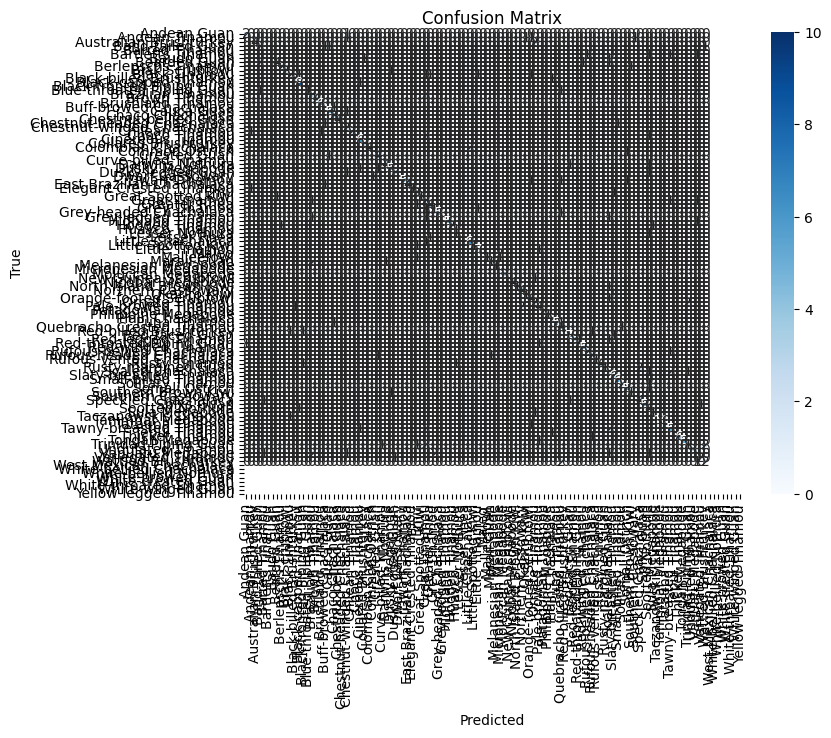

In [13]:
# Predict on validation data
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels

# Generate confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [14]:
# Get unique classes in y_val
unique_classes = np.unique(y_val)

# Generate classification report with explicit labels
print(classification_report(y_val, y_pred_classes, labels=unique_classes, target_names=label_encoder.inverse_transform(unique_classes)))

                            precision    recall  f1-score   support

               Andean Guan       0.67      0.67      0.67         3
            Andean Tinamou       0.00      0.00      0.00         4
    Australian Brushturkey       1.00      0.67      0.80         6
          Band-tailed Guan       0.40      0.40      0.40         5
         Bartletts Tinamou       0.00      0.00      0.00         4
                Baudo Guan       0.00      0.00      0.00         2
              Bearded Guan       0.80      0.50      0.62         8
        Berlepschs Tinamou       0.67      0.67      0.67         3
            Biak Scrubfowl       1.00      0.67      0.80         3
             Black Tinamou       0.50      0.29      0.36         7
  Black-billed Brushturkey       0.75      0.75      0.75         4
      Black-capped Tinamou       0.82      0.90      0.86        10
 Blue-throated Piping Guan       1.00      0.20      0.33         5
         Brazilian Tinamou       0.33      0.50

/Users/gokulgopank/Documents/Bird_1/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/gokulgopank/Documents/Bird_1/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/gokulgopank/Documents/Bird_1/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

### Create gradio interface

In [15]:
# Path to the downloaded shapefile (replace with your local path)
shapefile_path = "map/ne_110m_admin_0_countries.shp"

In [16]:
with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

In [17]:
# Path to the downloaded shapefile (replace with your local path)
shapefile_path = "map/ne_110m_admin_0_countries.shp"

# Sample countries to highlight
countries_to_highlight = ["United States of America", "Brazil", "India"]
data_csv =pd.read_csv("Birds Voice.csv")
model = tf.keras.models.load_model('yamnet_classifier_model.h5')
with open('label_encoder.pkl', 'rb') as f:
    label_encoder_3 = pickle.load(f)

def yamnet_embeddings(audio_data):
    audio_data = np.squeeze(audio_data) 
    scores, embeddings, spectrogram = yamnet_model(audio_data)
    return embeddings.numpy()  # Shape: (num_patches, 1024)

def test_inf(audio):
    sound = AudioSegment.from_mp3(audio)
    sound = sound.set_frame_rate(16000)  # Resample to 16kHz
    sound = sound.set_channels(1)        # Convert to mono
    sound.export("wav_test/w_1", format="wav")
    # Prepare the dataset by extracting embeddings
    all_embeddings = []
    audio_data = load_audio_file("wav_test/w_1")
    audio_data = np.reshape(audio_data, (1, -1))  # Reshape for batch dimension
    embeddings = yamnet_embeddings(audio_data)
    all_embeddings.append(np.mean(embeddings, axis=0))  # Use mean embedding
    X = np.array(all_embeddings) 
    predd = model.predict(X)
    predd_class_indices = predd.argmax(axis=1)
    # Now pass these indices to inverse_transform
    return label_encoder.inverse_transform(predd_class_indices)[0]


# Create world map using Plotly
def create_map(audio,country_spotted):

    c_name = data_csv[data_csv.common_name == test_inf(audio)].scientific_name.iloc[0]
    countries_seen = list(data_csv[data_csv.common_name == test_inf(audio)].Country.unique())
    
    # Load the world map from the shapefile
    world = gpd.read_file(shapefile_path)

    # Highlight the selected countries
    highlighted_countries = world[world['NAME'].isin(countries_seen)]
    
    # Plot the map with highlighted countries
    fig = px.choropleth(
        highlighted_countries,
        locations='NAME',
        locationmode='country names',
        color='NAME',
        title="Countries visited by bird in its usual fly path"
    )
    # Increase map size and reduce legend size
    fig.update_layout(
        width=800,  # Map width
        height=500,  # Map height
        legend=dict(
            orientation="h",   # Horizontal legend
            yanchor="top",     # Align legend at the top
            y=-0.2,            # Position legend below the map
            xanchor="center",  # Center align legend
            x=0.5,             # Center it horizontally
            font=dict(size=10)  # Legend font size
        )
       
        )
    if country_spotted in countries_seen:
        analysis = "Bird spotted in its expected country."
    else:
        analysis = "Bird spotted in acountry outside its migratory path. There is likely change in migratory path due to reasons such as climate change or deforestation."
    return fig,test_inf(audio), c_name, countries_seen, analysis

# Create Gradio interface
iface = gr.Interface(
    fn=create_map,
    inputs=[ gr.Audio(type="filepath", label="Andean Tinamou Sound"),
             gr.Textbox(value="Japan", label="Enter Country of Spotting)"),
            ],
    outputs=[gr.Plot(), gr.Textbox(value="Andean", label="Audio belongs to the bird"), gr.Textbox(value="Andean", label="Scientific name is"), 
             gr.Textbox(value="India, Australia", label="Countries of Migration are"),
             gr.Textbox(value="Bird sighted in an expected country", label="Analysis")
            ],
    examples = [["Voice of Birds/Voice of Birds/Andean Tinamou_sound/Andean Tinamou2.mp3"],["Voice of Birds/Voice of Birds/Andean Guan_sound/Andean Guan8.mp3"],[ "Voice of Birds/Voice of Birds/Common Ostrich_sound/Common Ostrich2.mp3"]],
    title="Migratory Birds tracking using audio signals",
    description="Upload audio of bird spotted along with country of spotting. Audio file should be around 5 to 20 seconds."
)

iface.launch()



Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
